In [1]:
import os
os.chdir("../")
os.getcwd()

'/home/bbd0953/diffusion/src'

# Training Loss

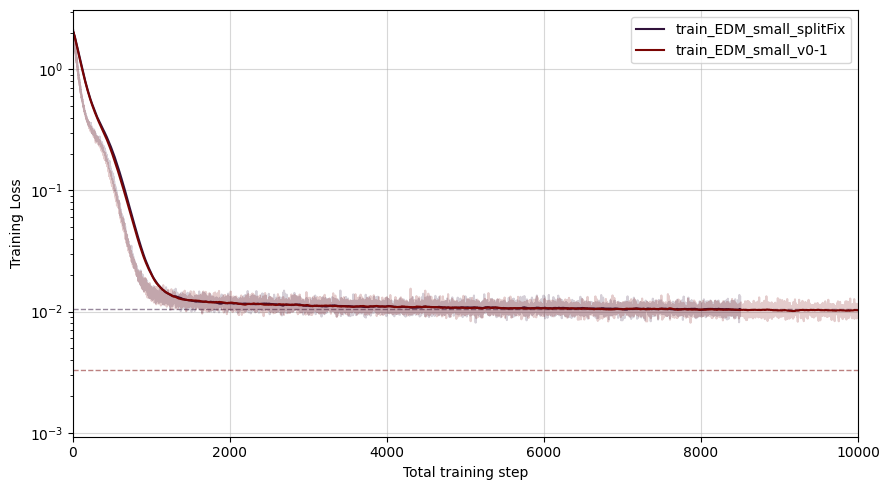

In [4]:
# Plot snapshot run losses
from pathlib import Path
import sys
from importlib import reload
from utils.plot_utils import plot_losses, add_loss_plot
reload(sys.modules['utils.plot_utils'])
import matplotlib as mpl
import numpy as np
model_dirs = [Path("/home/bbd0953/diffusion/results")/d for d in [
    'EDM_small_splitFix',
    # 'EDM_small',
    'EDM_small_v0-1',
    # 'EDM',
]]
loss_files = [f 
              for model_dir in model_dirs
              for f in sorted(list(model_dir.glob("losses_train*.csv")))
]


%matplotlib inline

fig, ax = plot_losses(loss_files, smooth=[200, ]*len(model_dirs))
ax.set_xlim(0, 10000)
#ax.set_ylim(9e-3, 3e-2)
fig.show()

In [7]:
fig.savefig("/home/bbd0953/diffusion/analysis_results/plots/train_losses_EMD_vs_small.pdf")

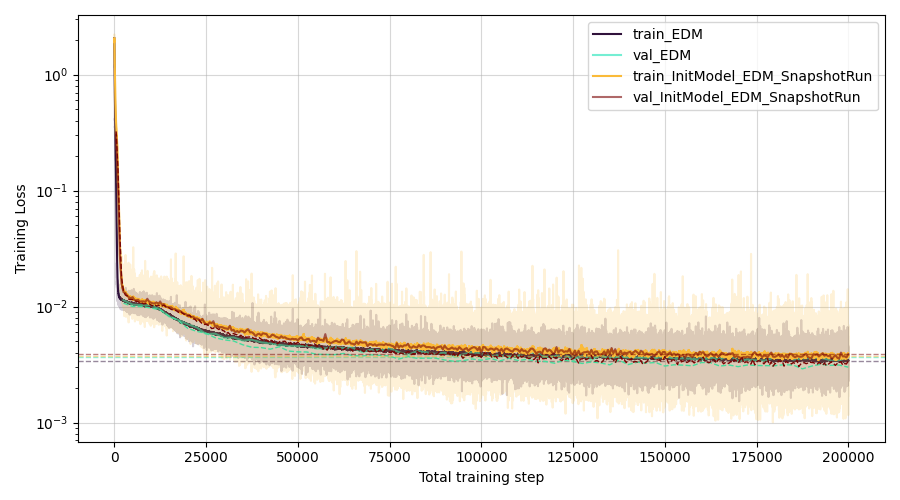

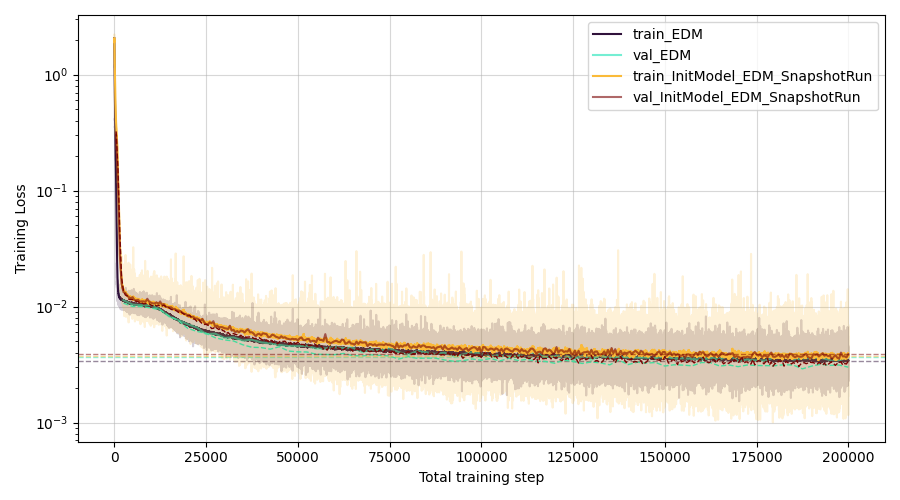

In [ ]:
# Plot snapshot run losses
from pathlib import Path
import sys
from importlib import reload
from utils.plot_utils import plot_losses, add_loss_plot
reload(sys.modules['utils.plot_utils'])
import matplotlib as mpl
import numpy as np
model_dirs = [Path("/home/bbd0953/diffusion/results")/d for d in [
    'EDM',
    'InitModel_EDM_SnapshotRun',
    # 'EDM_WarmUp_500_0,1',
    # 'EDM_MultiStep_1k-4k-7k-10k_0,5',
    # "EDM_lr=2e-5",
    # "EDM_warmup",
    # "EDM_lr_multistep_4x",
    # "EDM_lr_scheduler",
    # "EDM_lr=1e-4",
    # "InitModel_EDM_lr=2e-5_bsize=256_(1,2,2,2)"
]]
loss_files = [f 
              for model_dir in model_dirs
              for f in sorted(list(model_dir.glob("losses*.csv")))
]


%matplotlib widget

fig, ax = plot_losses(loss_files, smooth=[200, 0]*len(model_dirs))
# ax.set_xlim(0, 13000)
#ax.set_ylim(9e-3, 3e-2)
fig.show()

# Saliency Maps

Required:
- Load model
- Load Dataset to get examples
- Load diffusion for noise sampling & loss 
- Compute loss of gradient w.r.t. image
- Plot next to each other: Image, noised image, reconstructed image, saliency map 

In [ ]:
from pathlib import Path
from torch.utils.data import DataLoader
from utils.data_utils import LofarSubset
from utils.init_utils import load_model_from_folder, load_diffusion_from_folder

# Model folder
folder = Path(
    "/home/bbd0953/diffusion/results/InitModel_EDM_lr=2e-5_bsize=256_(1,2,2,2)"
)

# Load model
model = load_model_from_folder(folder)
model.eval()
model.to('cpu')
for param in model.parameters():
    param.requires_grad_(False)

# Load diffusion
diffusion = load_diffusion_from_folder(folder)


Loading model from /home/bbd0953/diffusion/results/InitModel_EDM_lr=2e-5_bsize=256_(1,2,2,2)/parameters_ema_InitModel_EDM_lr=2e-5_bsize=256_(1,2,2,2).pt and /home/bbd0953/diffusion/results/InitModel_EDM_lr=2e-5_bsize=256_(1,2,2,2)/config_InitModel_EDM_lr=2e-5_bsize=256_(1,2,2,2).json


In [ ]:
# Load dataset
dataset = LofarSubset()
dl = DataLoader(dataset, batch_size=1, shuffle=False, pin_memory=True)
itr = iter(dl)

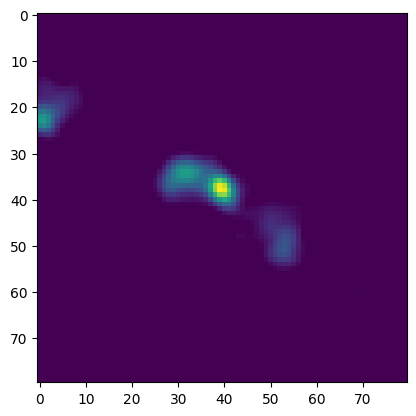

In [ ]:
import matplotlib.pyplot as plt

# Get example input
img = next(itr)
img.requires_grad = True
plt.imshow(img[0, 0, :, :].detach().numpy())

In [ ]:
import torch

sigma = diffusion.sample_sigmas(img)
noise = torch.randn_like(img) * sigma
noise.requires_grad = True

# Calculate loss
loss, output = diffusion.edm_loss(model, img, sigmas=sigma, noise=noise, 
                                  return_output=True)
loss.backward()

In [ ]:
slc = lambda x: x.grad[0, 0, :, :].detach().numpy()
chan = lambda x: x[0, 0, :, :].detach().numpy()

slc_img = slc(img)
chan_img = chan(img)

slc_noise = slc(noise)
chan_noise = chan(noise)

chan_output = chan(output)
chan_l2 = chan((output - img)**2)
chan_diff = chan((output - img))

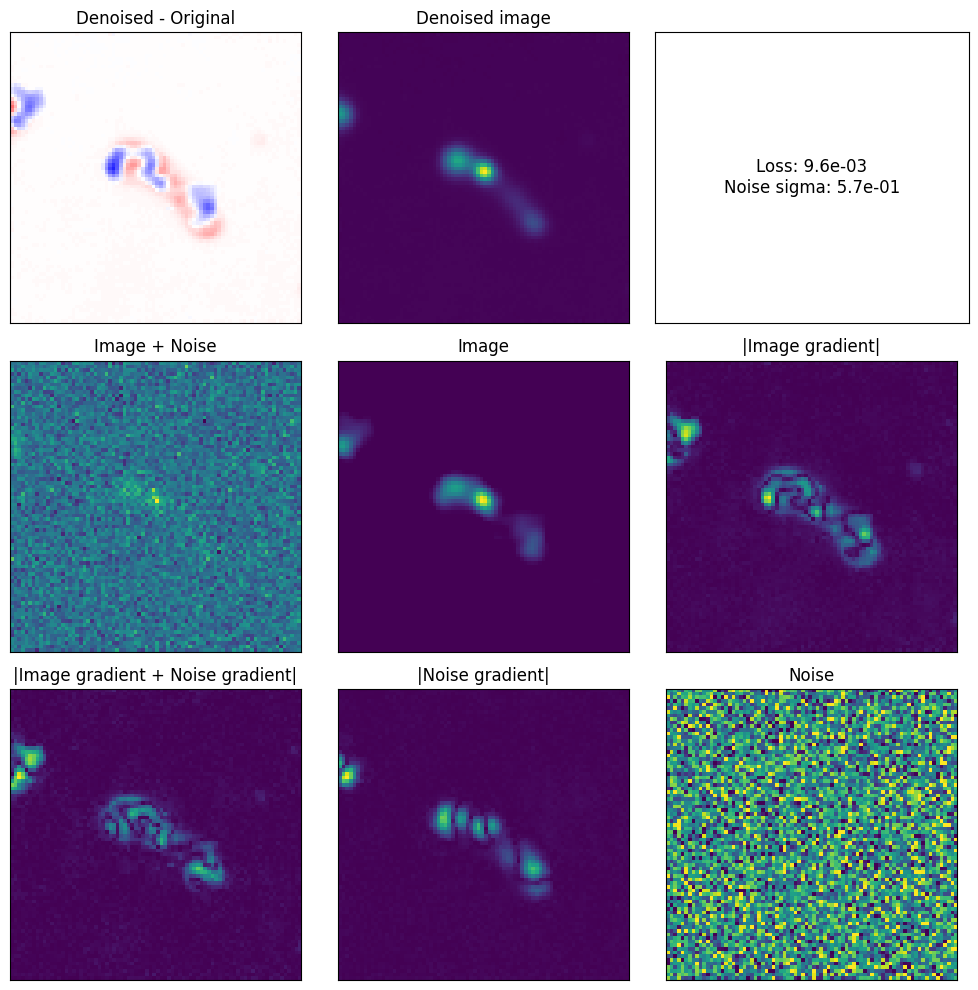

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 3, figsize=(10, 10), tight_layout=True)

axs[1, 1].imshow(chan_img)
axs[1, 1].set_title("Image")

axs[1, 2].imshow(np.abs(slc_img))
axs[1, 2].set_title("|Image gradient|")

axs[2, 2].imshow(chan_noise, vmin=-1, vmax=1)
axs[2, 2].set_title("Noise")

axs[2, 1].imshow(np.abs(slc_noise))
axs[2, 1].set_title("|Noise gradient|")

axs[1, 0].imshow(chan_img + chan_noise)
axs[1, 0].set_title("Image + Noise")

axs[2, 0].imshow(np.abs(slc_img + slc_noise))
axs[2, 0].set_title("|Image gradient + Noise gradient|")

axs[0, 1].imshow(chan_output)
axs[0, 1].set_title("Denoised image")

axs[0, 0].imshow(chan_diff, vmin=-1, vmax=1, cmap='seismic')
axs[0, 0].set_title("Denoised - Original")

axs[0, 2].text(
    0.5, 0.5,
    f"Loss: {loss.item():.1e}\nNoise sigma: {sigma.item():.1e}",
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=12,)


# Remove ticks on all axis
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

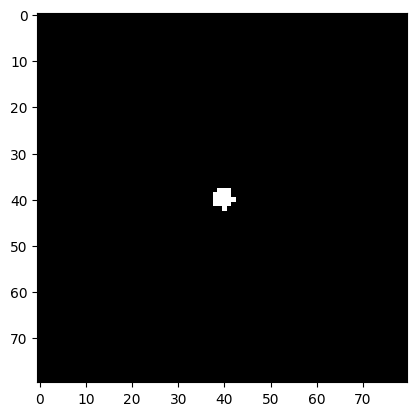

In [ ]:
plt.imshow(chan_output > 0, cmap="gray")

# Timestep Variations

In [7]:
# RUN THIS REGARLDESS OF WHICH PART

from pathlib import Path
from analysis.model_evaluations import (
    get_W1_lofar_score, get_distributions, get_distributions_lofar,
    per_bin_delta, example_plot
)
from utils.plot_utils import plot_distributions

# File paths used in analysis.model_evaluations
ANALYSIS_RESULTS_PARENT = Path("../analysis_results/timesteps_comparison")
GEN_DATA_PARENT = Path("../image_data/generated/timesteps_comparison")

# Useful functions
def quick_look_pixel_dist(img_dir):
    dis, _ = get_distributions(img_dir, force=True, save=True)
    distributions_lofar, _ = get_distributions_lofar()
    plot_distributions(dis, distributions_lofar,
    per_bin_delta(dis, distributions_lofar))

In [8]:
# List of all image directories
img_dirs = sorted([
    img_dir for img_dir in GEN_DATA_PARENT.glob('*') if img_dir.is_dir()
], key=lambda x: int(x.stem.split('=')[-1])
)
img_dirs

[PosixPath('../image_data/generated/timesteps_comparison/samples_EDM_T=2'),
 PosixPath('../image_data/generated/timesteps_comparison/samples_EDM_T=5'),
 PosixPath('../image_data/generated/timesteps_comparison/samples_EDM_T=10'),
 PosixPath('../image_data/generated/timesteps_comparison/samples_EDM_T=25'),
 PosixPath('../image_data/generated/timesteps_comparison/samples_EDM_T=50')]

In [9]:
# Access and plot pixel statistics
act_thresh = 1 / 255

# Get list with distributions from all image directories
distributions = [
    get_distributions(d, 
                      parent=ANALYSIS_RESULTS_PARENT, 
                      act_threshold=act_thresh,
                      save=False) for d in img_dirs[2:]
]

# Get lofar distributions
distributions_lofar = get_distributions_lofar(act_threshold=act_thresh, save=False)

# List with per-bin errors
per_bin_errors = [per_bin_delta(d, distributions_lofar) for d in distributions]

Loading images...


100%|███████████████████████████████████| 80000/80000 [00:13<00:00, 5745.37it/s]


Data set initialized.


Calculating distributions...: 100%|██████████| 160/160 [00:21<00:00,  7.46it/s]


Loading images...


100%|███████████████████████████████████| 80000/80000 [00:13<00:00, 5941.18it/s]


Data set initialized.


Calculating distributions...: 100%|██████████| 160/160 [00:20<00:00,  7.66it/s]


Loading images...


100%|███████████████████████████████████| 80000/80000 [00:13<00:00, 5826.71it/s]


Data set initialized.


Calculating distributions...: 100%|██████████| 160/160 [00:19<00:00,  8.15it/s]


Loading images...


100%|███████████████████████████████████| 84404/84404 [00:17<00:00, 4749.16it/s]


Data set initialized.


Calculating distributions...: 100%|██████████| 169/169 [00:20<00:00,  8.25it/s]


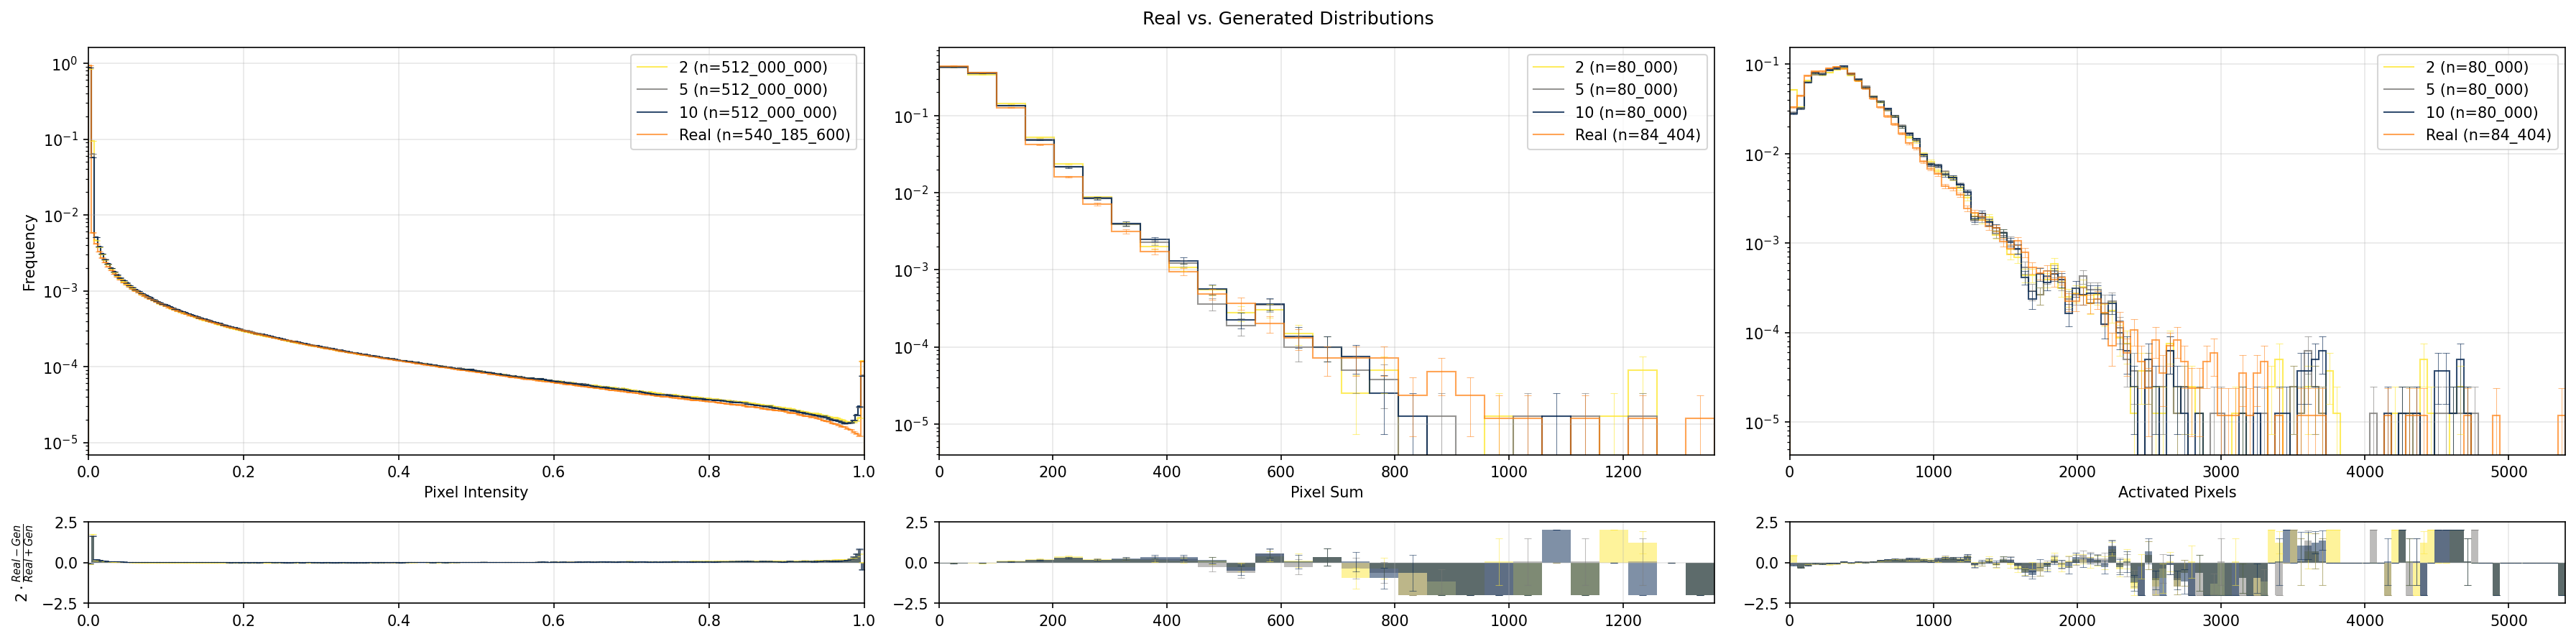

In [10]:
# Plot distributions
from importlib import reload
import utils.plot_utils
reload(utils.plot_utils)
from utils.plot_utils import plot_distributions
%matplotlib inline

labels = [img_dir.stem.split('_')[-1] for img_dir in img_dirs[2:]]
fig = plot_distributions(distributions, distributions_lofar, per_bin_errors, 
                   labels=labels, landscape_mode=True)

In [12]:
fig.savefig("/home/bbd0953/diffusion/analysis_results/plots/timesteps_comparison_distributions_threshold=1:255.pdf")

Found existing distribution file for samples_EDM_T=2.
Found existing distribution file for lofar_subset.
Found existing distribution file for samples_EDM_T=5.
Found existing distribution file for lofar_subset.
Found existing distribution file for samples_EDM_T=10.
Found existing distribution file for lofar_subset.
Found existing distribution file for samples_EDM_T=25.
Found existing distribution file for lofar_subset.
Found existing distribution file for samples_EDM_T=50.
Found existing distribution file for lofar_subset.


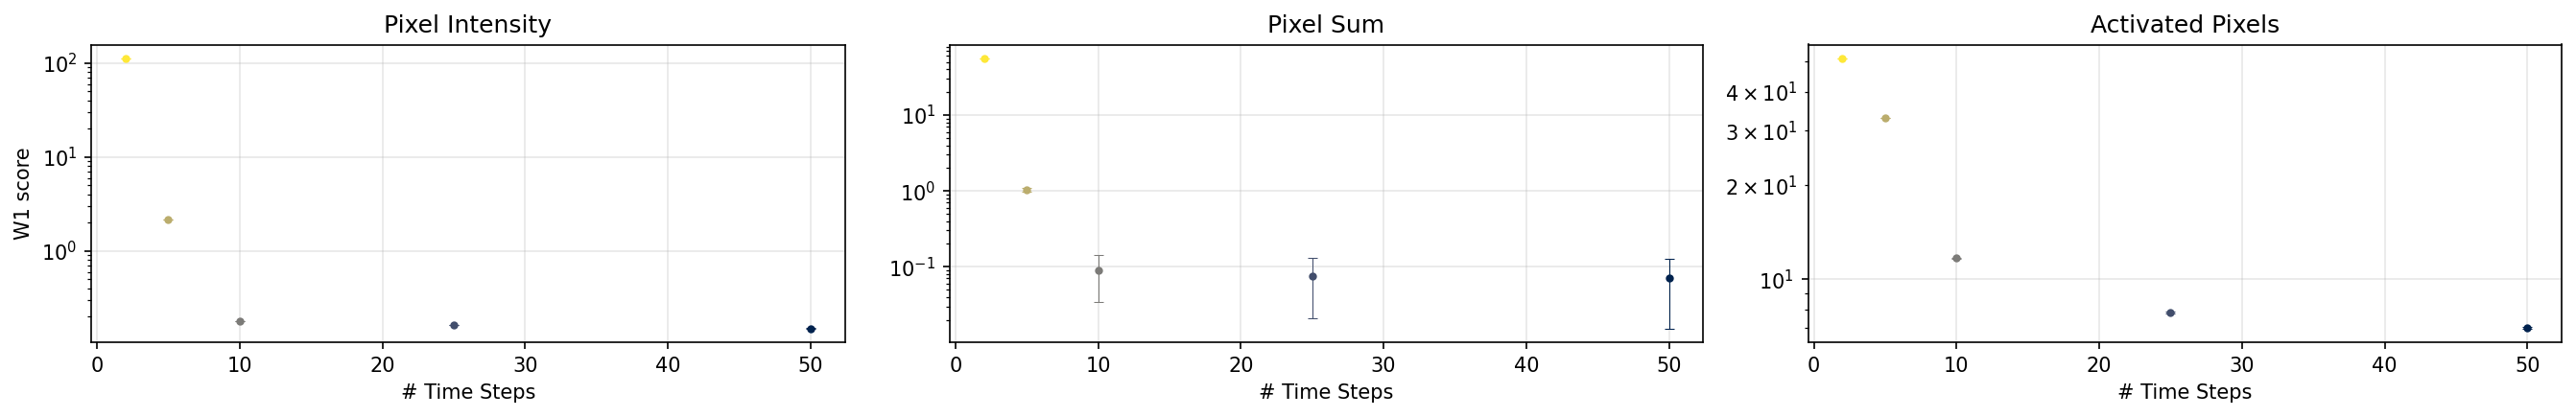

In [11]:
# Plot W1 scores
from importlib import reload
import utils.plot_utils
reload(utils.plot_utils)
from utils.plot_utils import plot_W1_scores

scores_list = [
    get_W1_lofar_score(img_dir, force=True, parent=ANALYSIS_RESULTS_PARENT)
     for img_dir in img_dirs
]

iters = [int(label.split('=')[-1]) for label in labels]
fig, axs = plot_W1_scores(scores_list, iters, x_label="# Time Steps", landscape_mode=True)
for ax in axs:
    # log scale
    ax.set_yscale('log')

In [12]:
fig.savefig("/home/bbd0953/diffusion/analysis_results/plots/timesteps_comparison_W1_scores.pdf")

# Checkpoint Run Analysis

In [ ]:
# RUN THIS REGARLDESS OF WHICH PART

from pathlib import Path
from analysis.model_evaluations import (
    get_W1_lofar_score, get_distributions, get_distributions_lofar,
    per_bin_delta, example_plot
)
from utils.plot_utils import plot_distributions

# File paths used in analysis.model_evaluations
ANALYSIS_RESULTS_PARENT = Path("../analysis_results/snapshot_run")
GEN_DATA_PARENT = Path("../image_data/generated/snapshot_run")
# Generate parent directories
ANALYSIS_RESULTS_PARENT.mkdir(exist_ok=True)
GEN_DATA_PARENT.mkdir(exist_ok=True)

# File paths used for generating data and plotting distributions
model_dir = Path("../results/InitModel_EDM_SnapshotRun")
config_file = model_dir / 'config_InitModel_EDM_SnapshotRun.json'
snapshot_dir = model_dir / 'snapshots'

# Useful functions
def quick_look_pixel_dist(img_dir):
    dis, _ = get_distributions(img_dir, force=True, save=True)
    distributions_lofar, _ = get_distributions_lofar()
    plot_distributions(dis, distributions_lofar,
    per_bin_delta(dis, distributions_lofar))


## Sampling

In [3]:
# Define functions to sample images and calculate pixel distributions
import torch
from model.sample import sample_n_batches
from utils.device_utils import distribute_model

# Global variables for sampling
n_devices = 4
bsize = 512 * n_devices
n_batches = 4
T = 1000

def snapshot_eval(model, file, diffusion):
    # Load param dict from file
    checkpoint = torch.load(file, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint)
    model = distribute_model(model, n_devices)


    # Specify model naming
    model_name = file.stem
    img_dir = GEN_DATA_PARENT / model_name
    img_dir.mkdir(exist_ok=True)

    # Sample data set
    sample_n_batches(model, diffusion, img_dir, bsize, n_batches)

    # Get distributions and W1 score
    get_W1_lofar_score(img_dir)


In [4]:
# Execute sampling and distribution calculation for all snapshots
from utils.init_utils import load_config, load_model
from model.diffusion import EDM_Diffusion

# Load model and diffusion
model = load_model(config_file)
diffusion = EDM_Diffusion.from_config(load_config(config_file))
diffusion.timesteps = T

# Get all ema files in snapshot directory
ema_files = [
    file for file in snapshot_dir.glob('*.pt') if file.stem.startswith('ema')
]
# Evaluate all snapshots
for file in ema_files:
    print(f"\n\nEvaluating {file.stem}")
    snapshot_eval(model, file, diffusion)



Evaluating ema_iter_120000


Sampling...: 100%|██████████| 50/50 [04:01<00:00,  4.83s/it]
Saving...: 2048it [00:02, 777.30it/s]
Sampling...: 100%|██████████| 50/50 [03:57<00:00,  4.74s/it]
Saving...: 2048it [00:02, 775.08it/s]
Sampling...:  56%|█████▌    | 28/50 [02:14<01:45,  4.80s/it]

## Statistics

In [8]:
# Access and plot pixel statistics

# List of all image directories
img_dirs = sorted([
    img_dir for img_dir in GEN_DATA_PARENT.glob('*') if img_dir.is_dir()
], key=lambda x: int(x.stem.split('_')[-1][:-4])
)

# Get list with distributions from all image directories
distributions = [get_distributions(d) for d in img_dirs]

# Get lofar distributions
distributions_lofar = get_distributions_lofar()

# List with per-bin errors
per_bin_errors = [per_bin_delta(d, distributions_lofar) for d in distributions]

Found existing distribution file for ema_iter_80000T=50.
Found existing distribution file for ema_iter_120000T=50.
Found existing distribution file for ema_iter_140000T=50.
Found existing distribution file for ema_iter_180000T=50.
Found existing distribution file for ema_iter_200000T=50.
Found existing distribution file for lofar_subset.


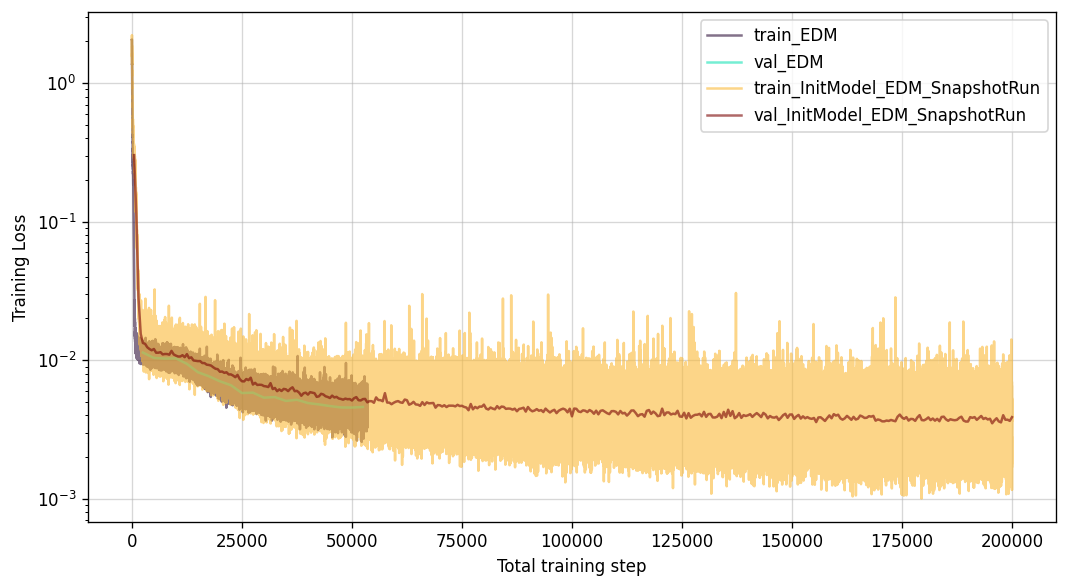

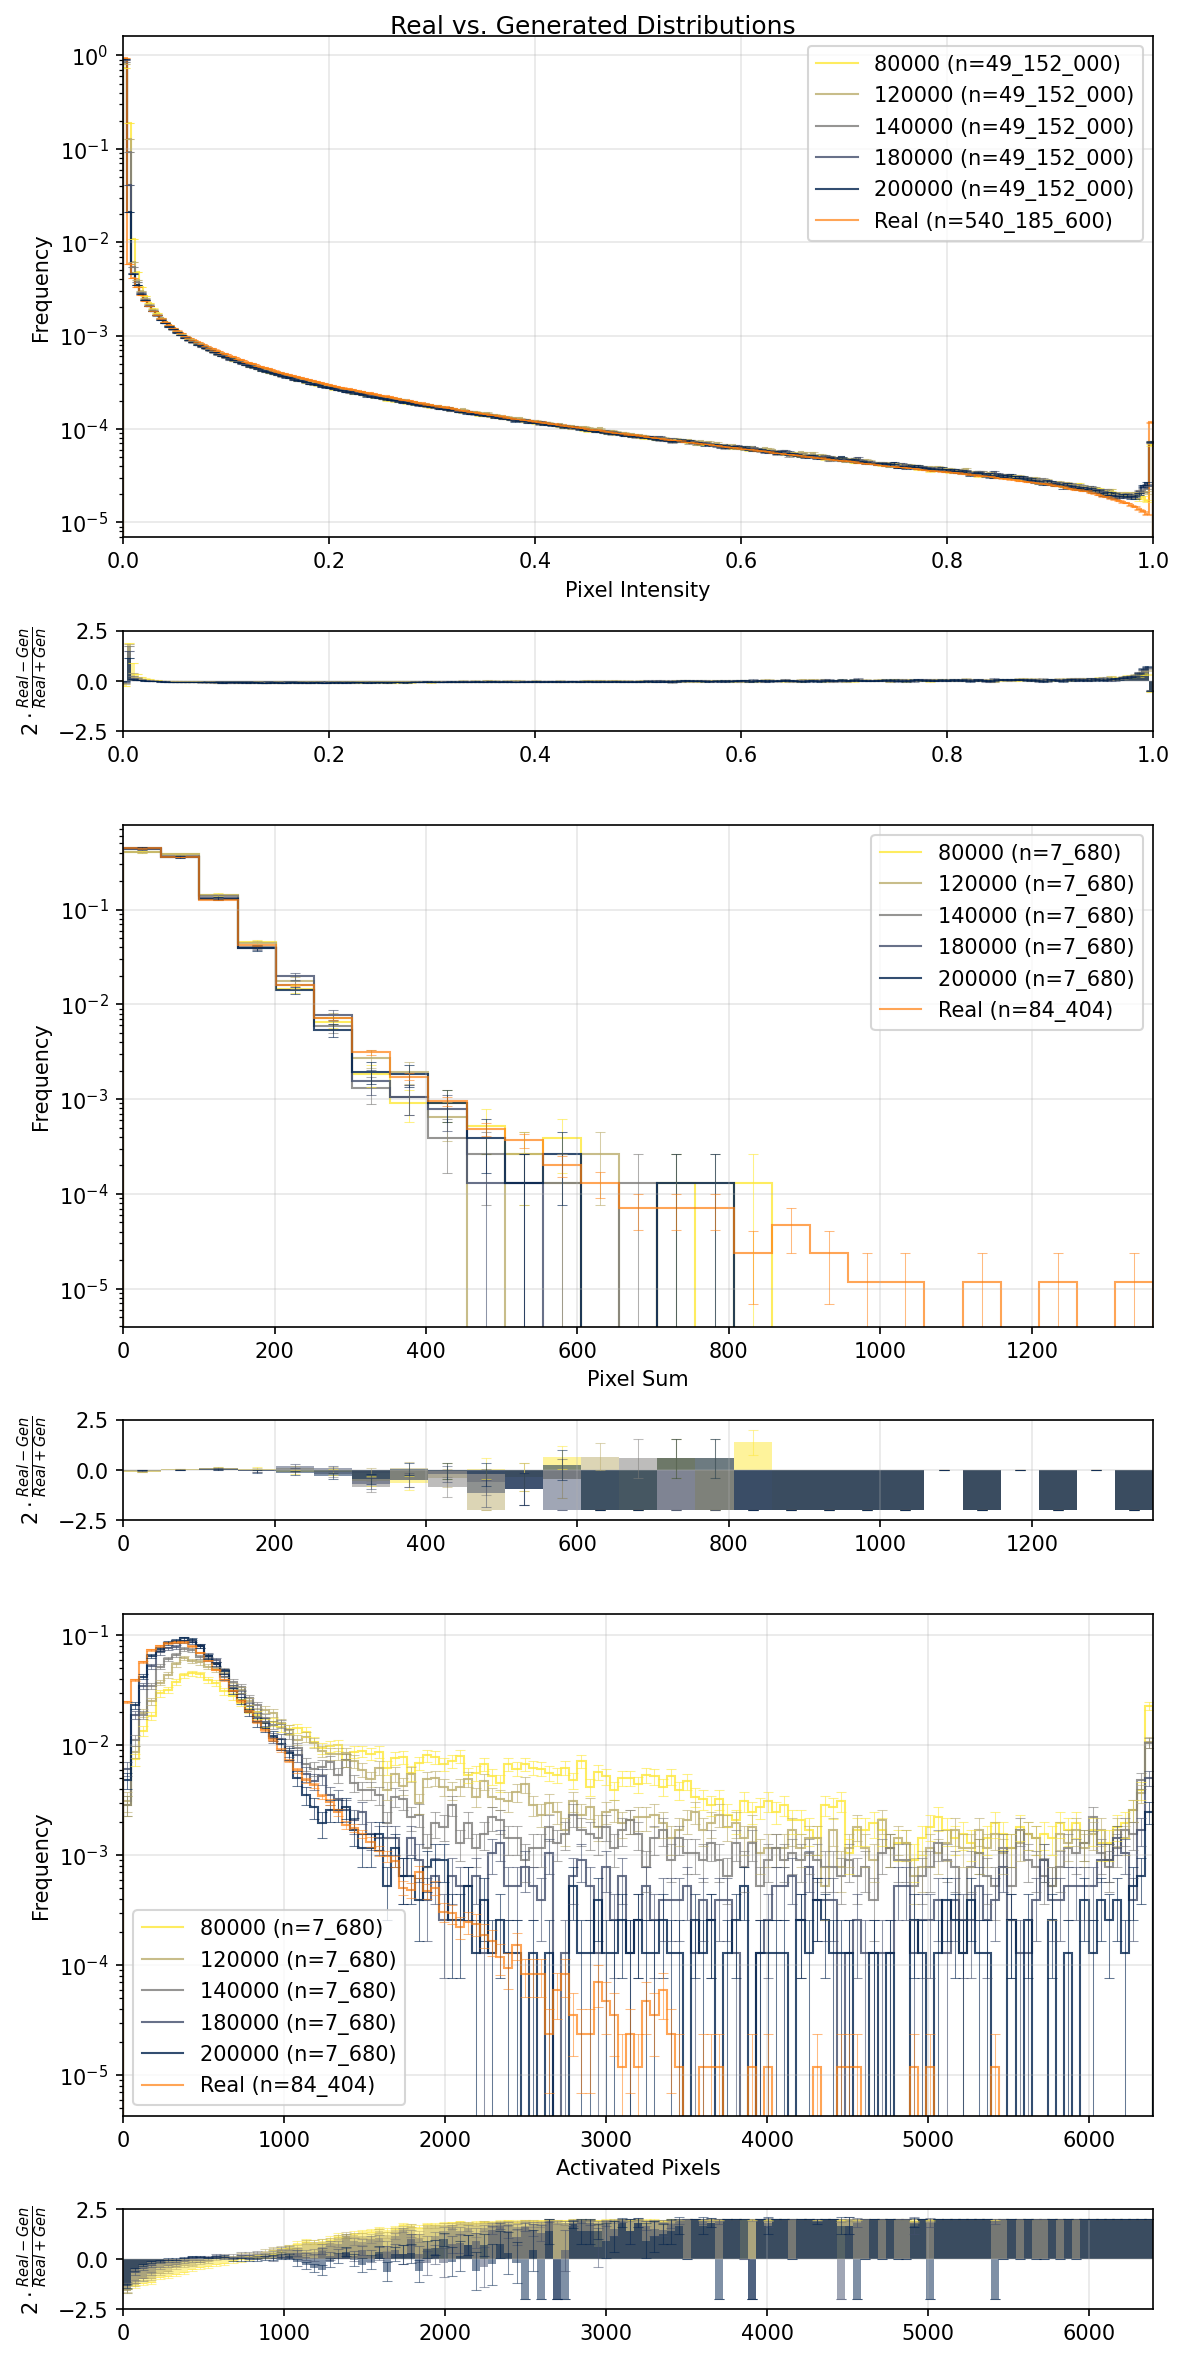

In [9]:
# Plot distributions
from importlib import reload
import utils.plot_utils
reload(utils.plot_utils)
from utils.plot_utils import plot_distributions
%matplotlib inline

labels = [img_dir.stem.split('_')[-1][:-4] for img_dir in img_dirs]
fig = plot_distributions(distributions, distributions_lofar, per_bin_errors, 
                   labels=labels, landscape_mode=False)

In [6]:
fig.savefig('../analysis_results/dataset_comparisons/distributions_snapshots_landscape.pdf', dpi=300)

In [11]:
# Get W1 stats:
import analysis.model_evaluations
reload(analysis.model_evaluations)
from analysis.model_evaluations import get_W1_lofar_score

# Get W1 scores
scores_list = [get_W1_lofar_score(img_dir, force=True) for img_dir in img_dirs]

Found existing distribution file for ema_iter_80000T=50.
Found existing distribution file for lofar_subset.
Found existing distribution file for ema_iter_120000T=50.
Found existing distribution file for lofar_subset.
Found existing distribution file for ema_iter_140000T=50.
Found existing distribution file for lofar_subset.
Found existing distribution file for ema_iter_180000T=50.
Found existing distribution file for lofar_subset.
Found existing distribution file for ema_iter_200000T=50.
Found existing distribution file for lofar_subset.


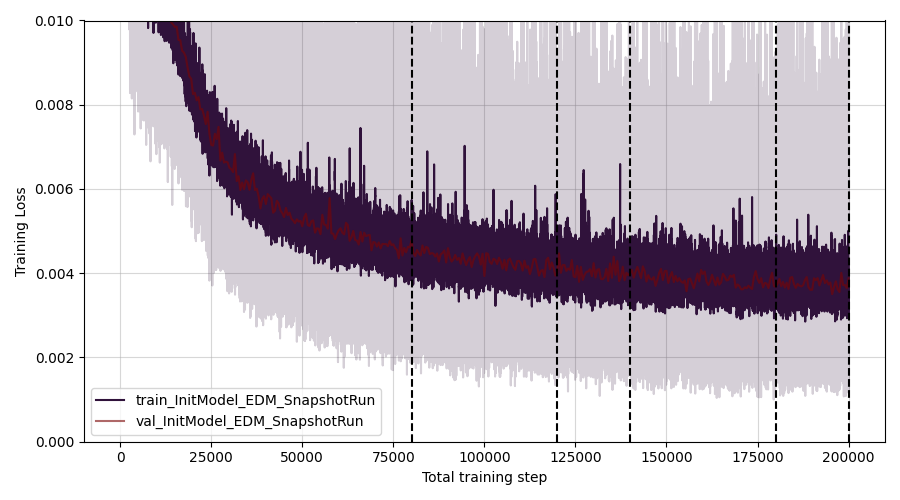

In [18]:
# Plot losses with lines at snapshots
from importlib import reload
import utils.plot_utils
reload(utils.plot_utils)
from utils.plot_utils import plot_losses_from_folder

%matplotlib widget
fig, ax = plot_losses_from_folder(model_dir)
ax.set_yscale('linear')
ax.set_ylim(0, 1e-2)

snapshots = [int(l) for l in labels]
# Add vertical dashed lines at snapshots
for s in snapshots:
    ax.axvline(s, color='k', linestyle='--')

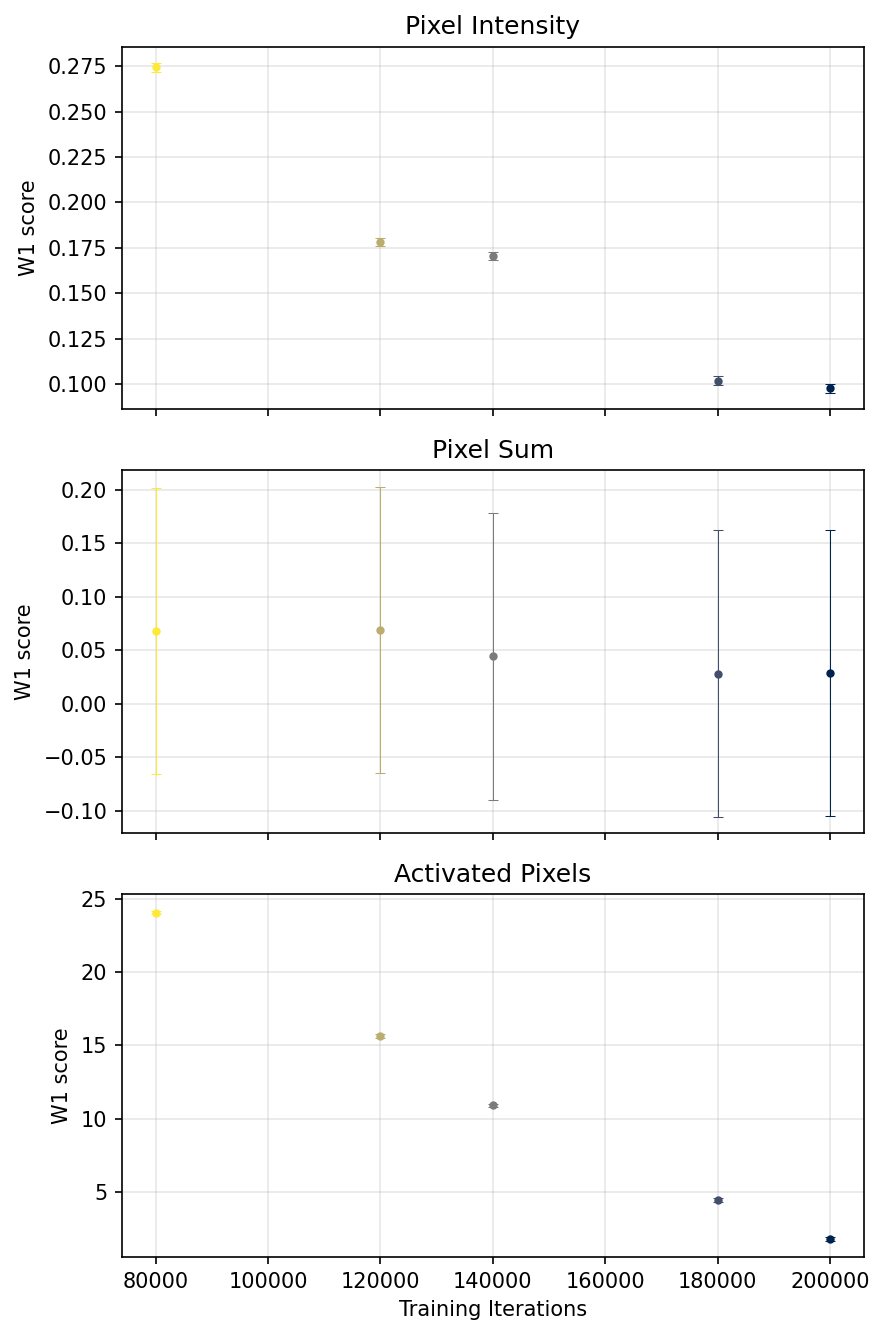

In [12]:
# Plot W1 scores
from importlib import reload
import utils.plot_utils
reload(utils.plot_utils)
from utils.plot_utils import plot_W1_scores

labels = [img_dir.stem.split('_')[-1][:-4] for img_dir in img_dirs]
iters = [int(label) for label in labels]
fig = plot_W1_scores(scores_list, iters, x_label="Training Iterations")

In [ ]:
fig.savefig('../analysis_results/dataset_comparisons/losses_snapshots.pdf', dpi=100)

In [28]:
fig.savefig('../analysis_results/dataset_comparisons/W1_snapshots_landscape.pdf', dpi=150)

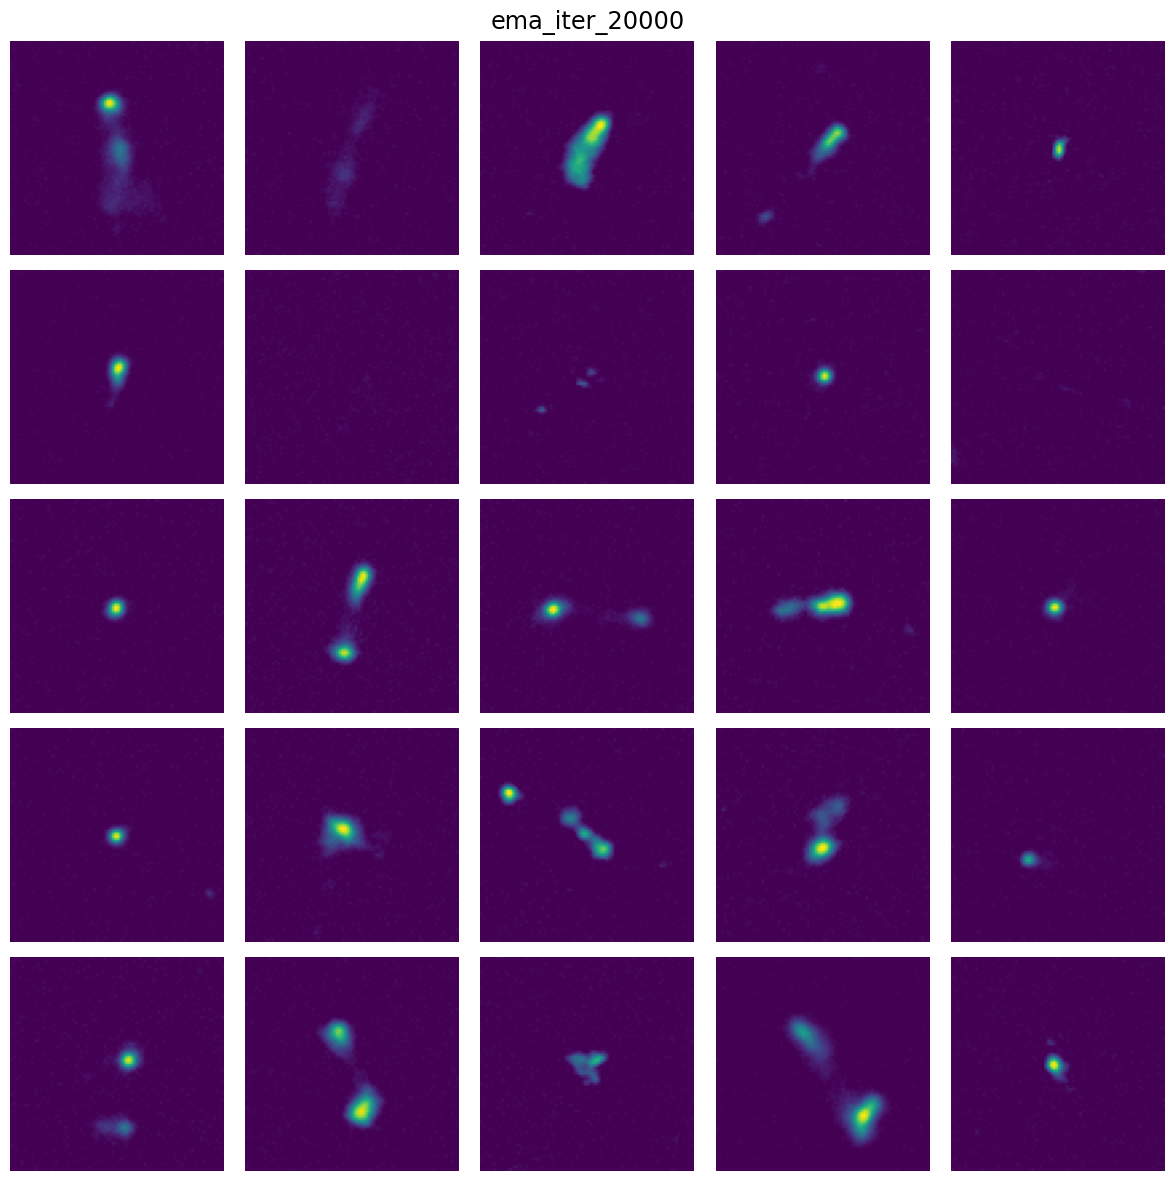

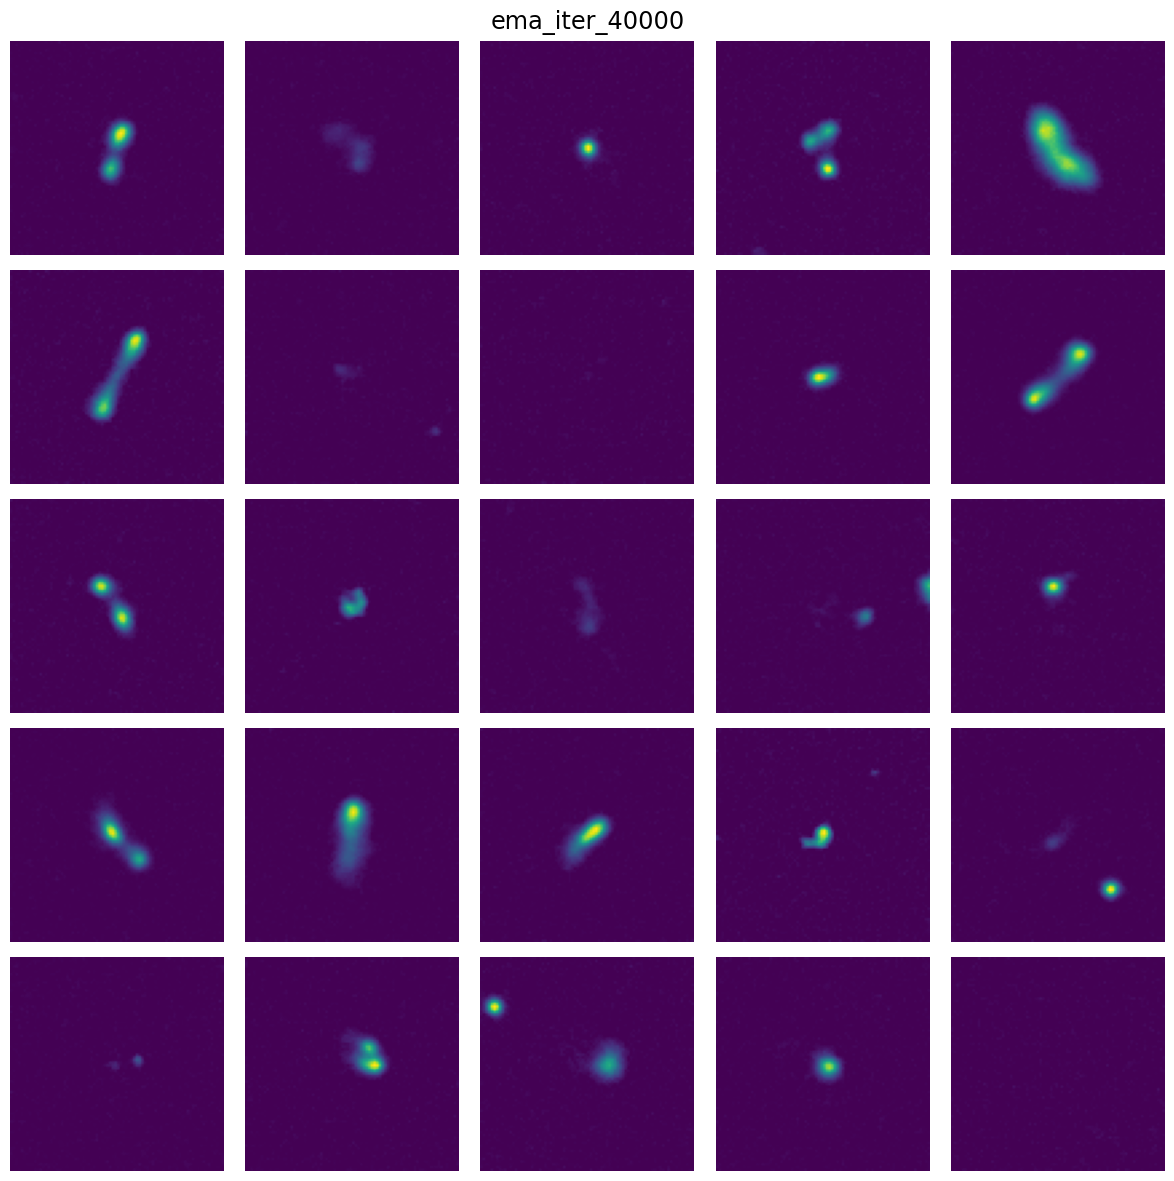

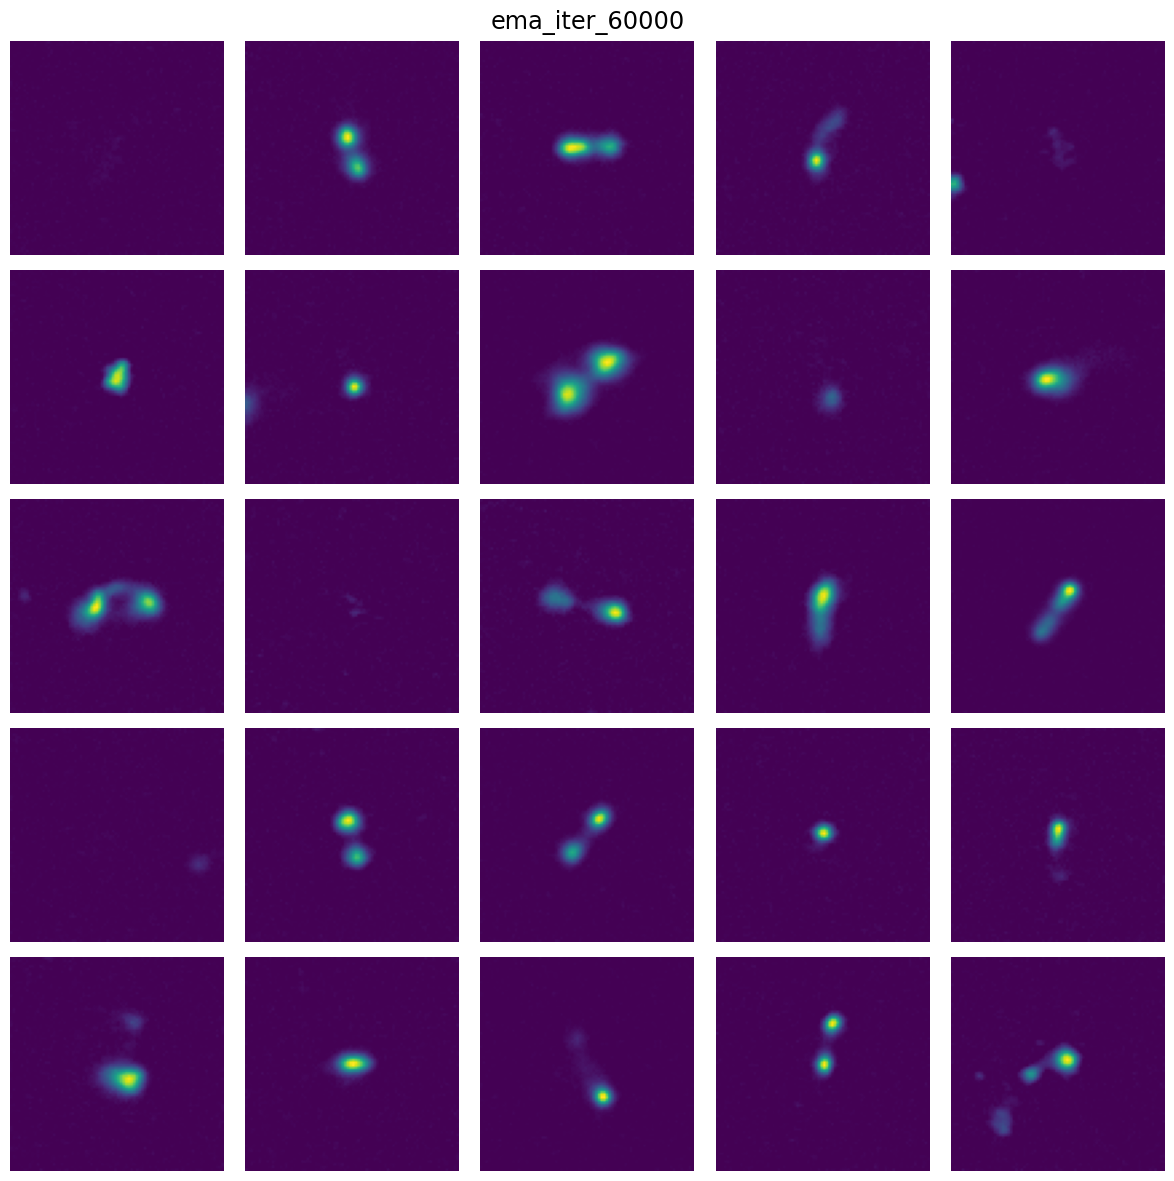

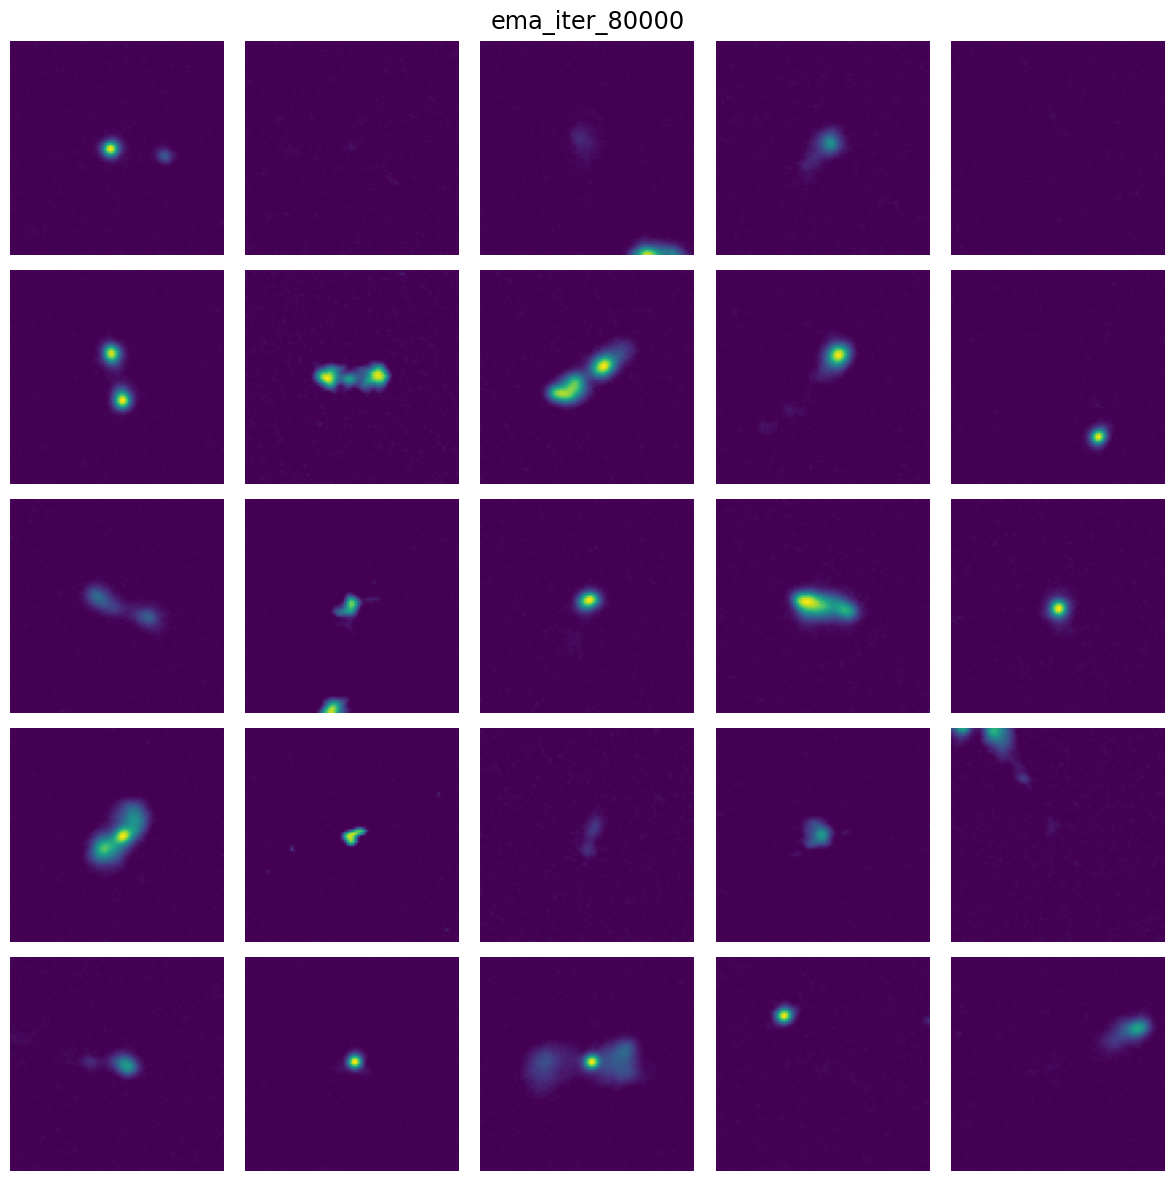

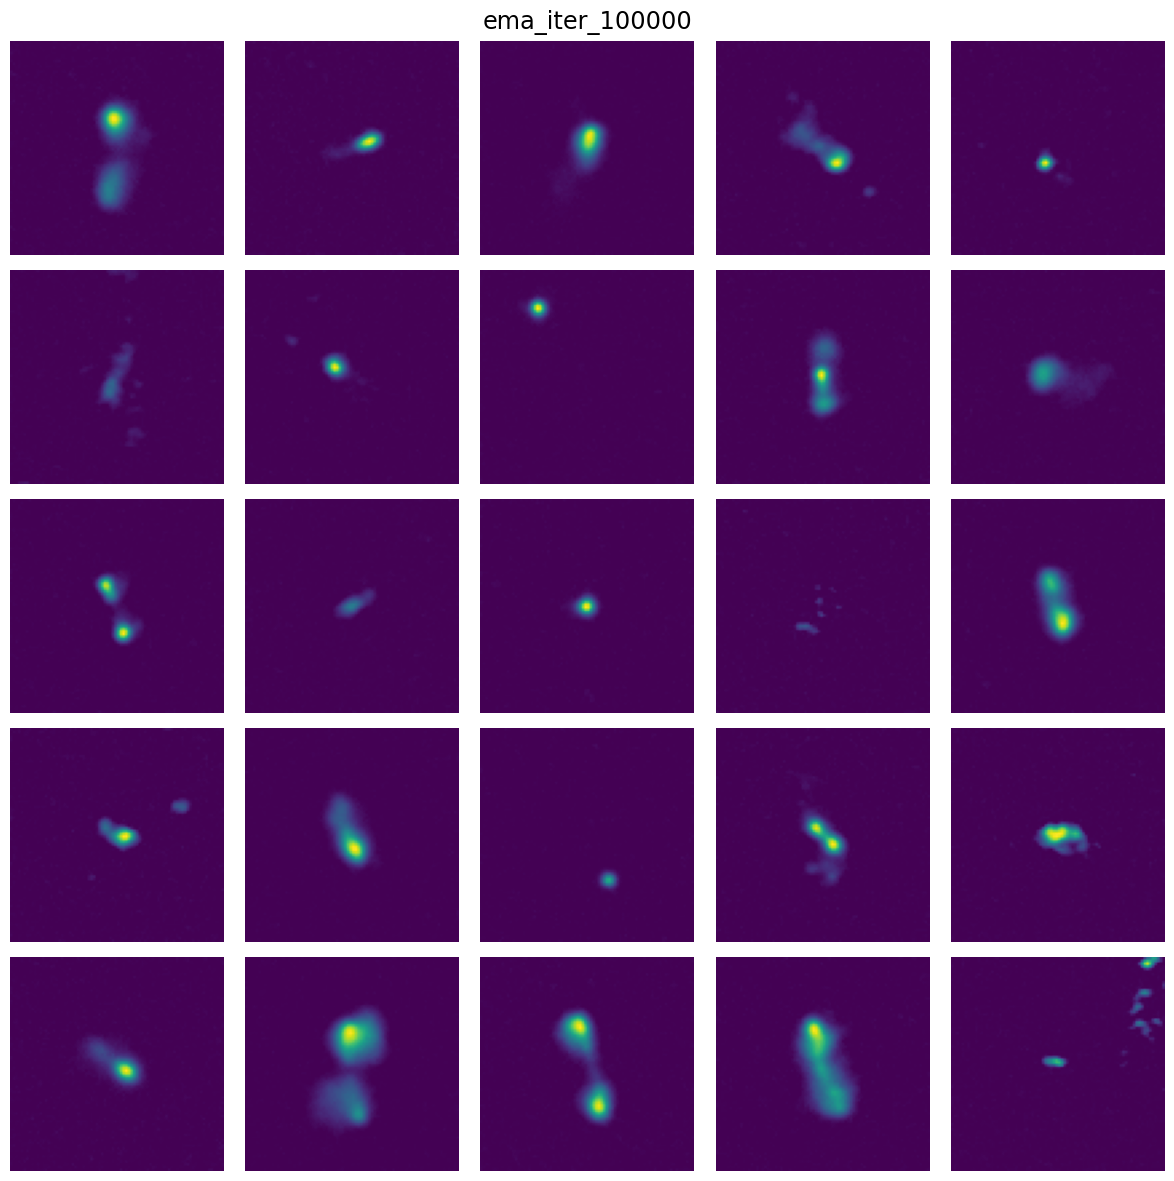

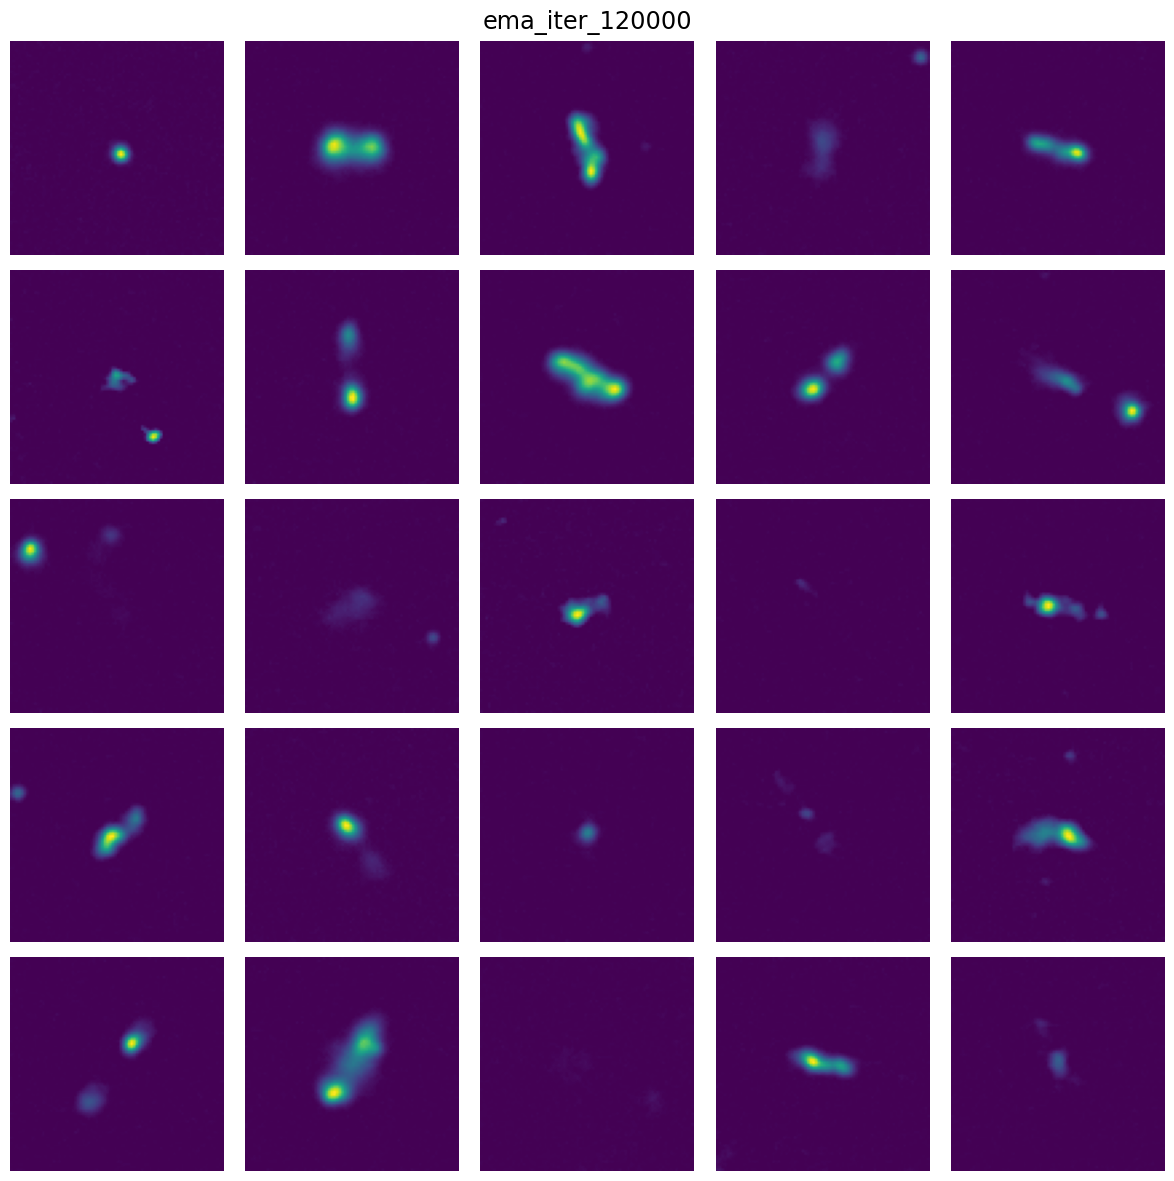

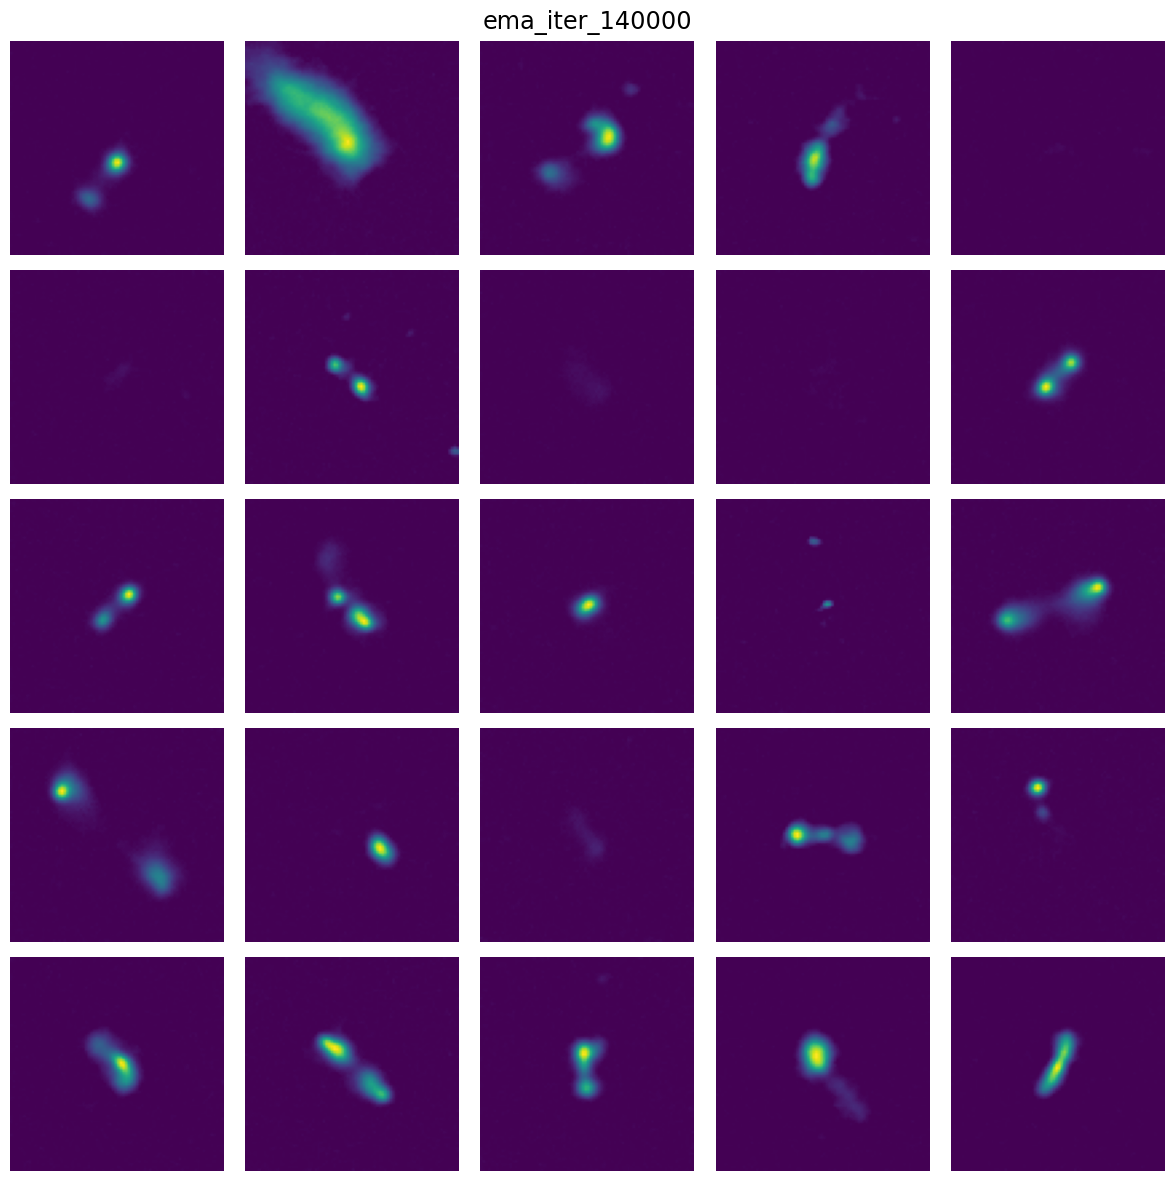

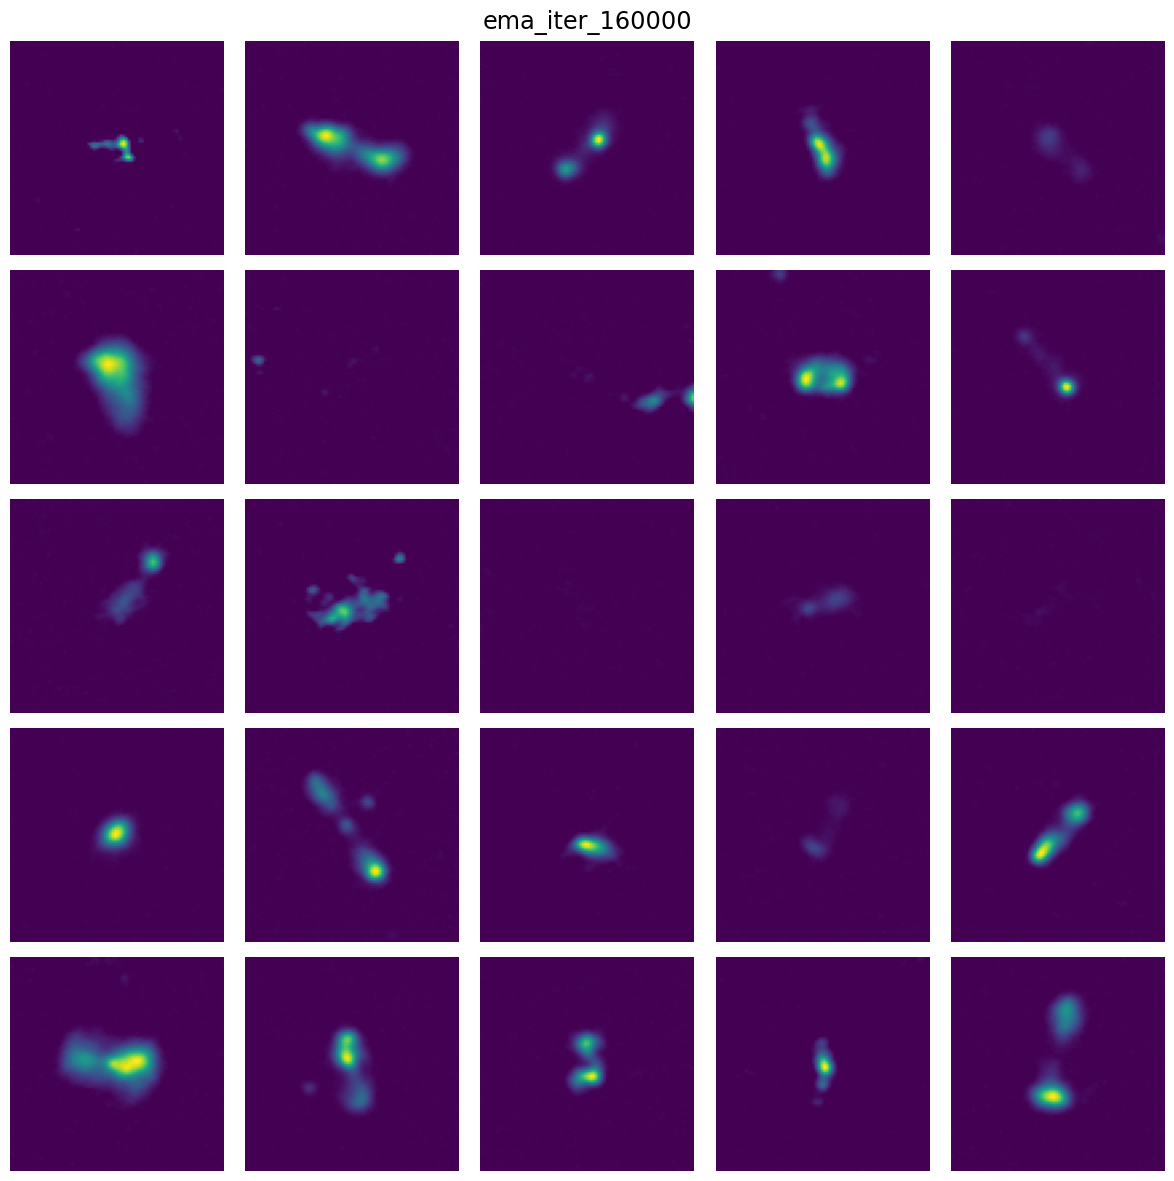

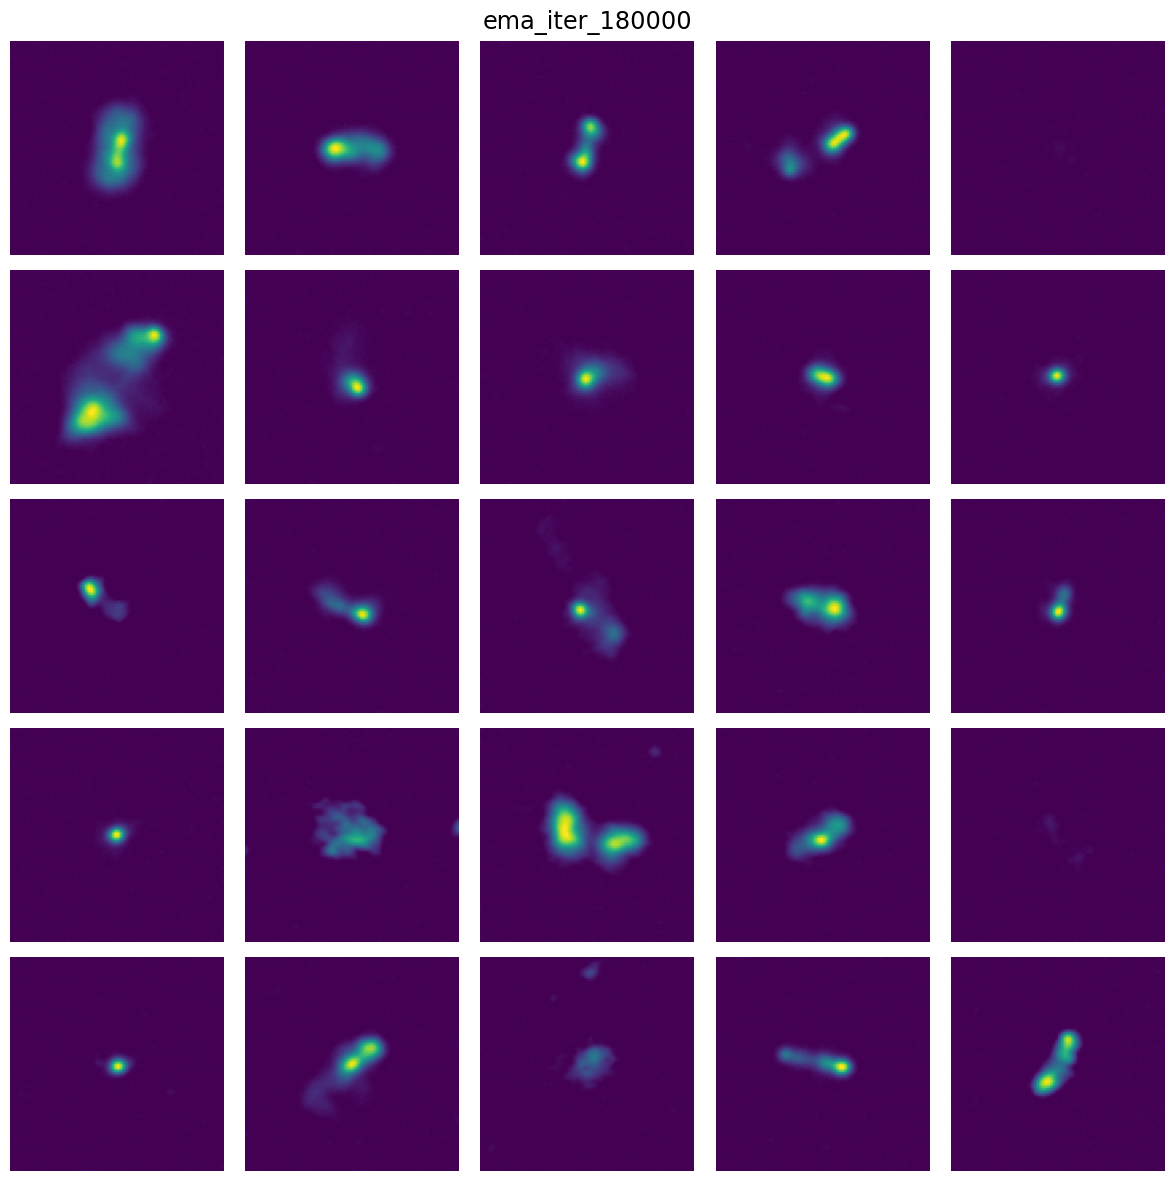

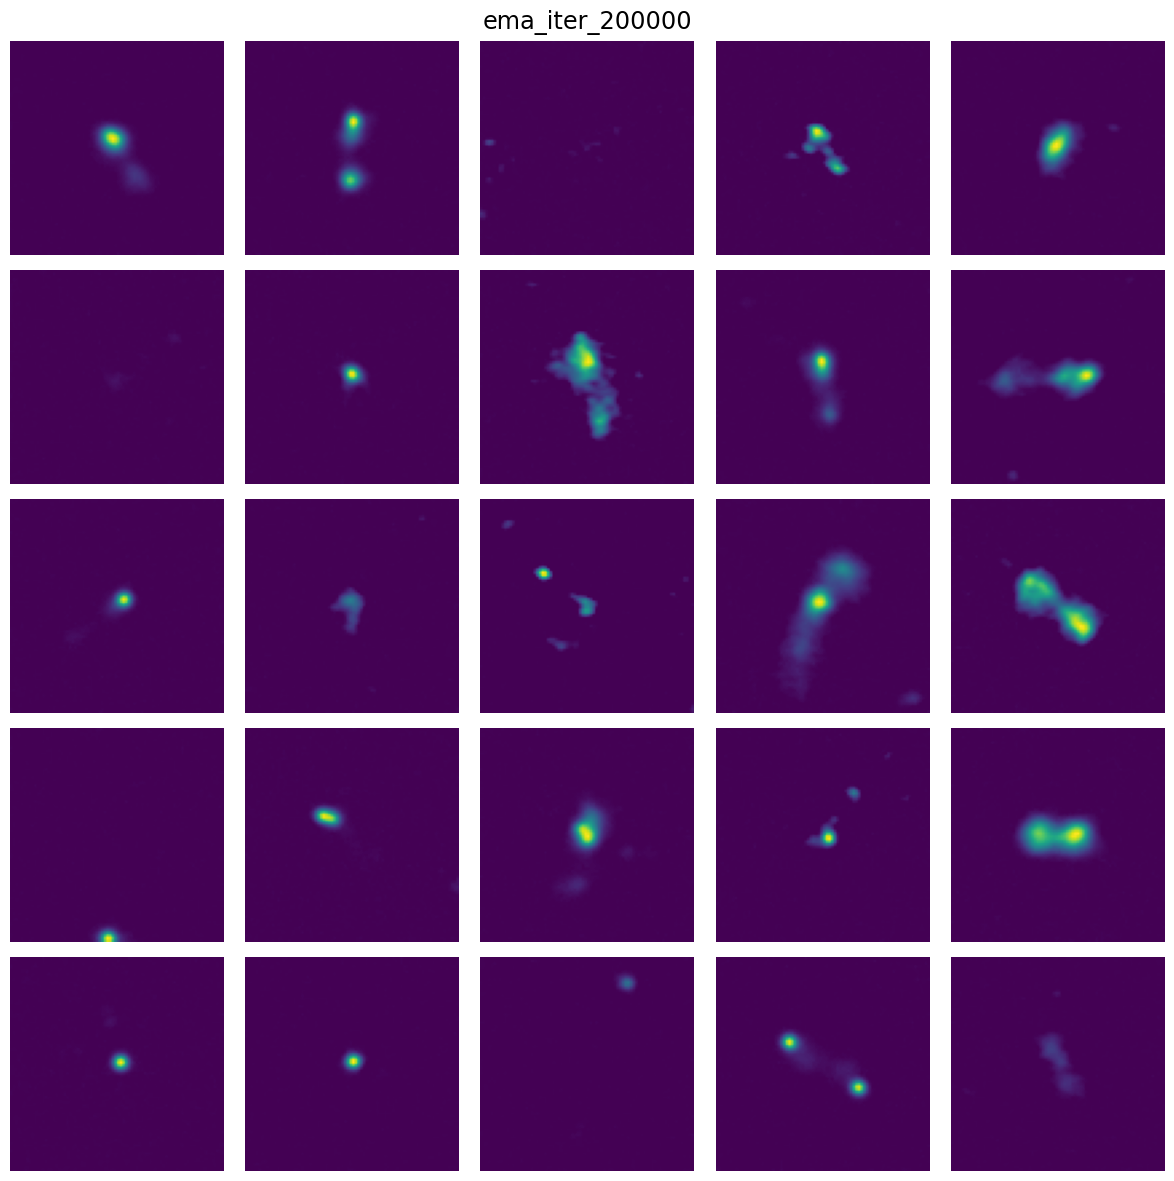

In [8]:
for d in img_dirs:
    example_plot(d)

# Tuning

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colormaps as cmaps
import numpy as np
import pandas as pd
from ray.tune import ResultGrid

def plot_loss_curves(result_grid: ResultGrid, metric: str, cmap="turbo"):
    """Plots the loss curves of a Ray Tune result grid."""
    fig, ax = plt.subplots(dpi=150)
    n_results = len(result_grid)
    # Create list of colors from color bar
    colors = cmaps[cmap](np.linspace(0, 1, n_results))
    for i, result in enumerate(result_grid):
        # Get the data from the result grid.
        data = result.metrics_dataframe

        # Extract the hyperparameters and metric values.
        x_values = data["training_iteration"]
        y_values = data[metric]

        # Create the plot.
        ax.plot(x_values, y_values, alpha=0.7, color=colors[i])
    ax.set_xlabel("Training Iteration")
    ax.set_ylabel(metric)
    ax.set_yscale("log")
    ax.grid(alpha=0.1)
    plt.show()
    return fig, ax

In [3]:
from pathlib import Path
from model.tune import train_wrapper
from ray import tune

# Load result grid
resultFolder = Path(
    "/home/bbd0953/diffusion/results/tune/lr_(1,2,2,2)_fromScratch"
)
results = tune.Tuner.restore(str(resultFolder), trainable=train_wrapper).get_results()

In [5]:
help(results)

Help on ResultGrid in module ray.tune.result_grid object:

class ResultGrid(builtins.object)
 |  ResultGrid(experiment_analysis: ray.tune.analysis.experiment_analysis.ExperimentAnalysis)
 |  
 |  A set of ``Result`` objects for interacting with Ray Tune results.
 |  
 |  You can use it to inspect the trials and obtain the best result.
 |  
 |  The constructor is a private API. This object can only be created as a result of
 |  ``Tuner.fit()``.
 |  
 |  Example:
 |  .. testcode::
 |  
 |      import random
 |      from ray import train, tune
 |      def random_error_trainable(config):
 |          if random.random() < 0.5:
 |              return {"loss": 0.0}
 |          else:
 |              raise ValueError("This is an error")
 |      tuner = tune.Tuner(
 |          random_error_trainable,
 |          run_config=train.RunConfig(name="example-experiment"),
 |          tune_config=tune.TuneConfig(num_samples=10),
 |      )
 |      try:
 |          result_grid = tuner.fit()
 |      except

In [25]:
best = results.get_best_result()

In [26]:
best.config

{'learning_rate': 0.00012}

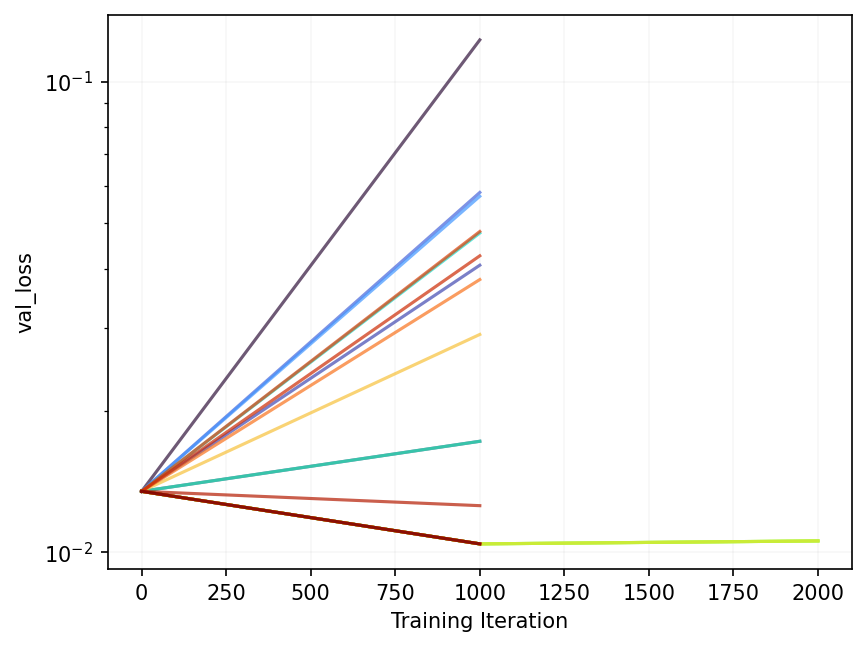

(0.01, 0.13866871153245677)

In [23]:
fig, ax = plot_loss_curves(results, "val_loss")
ax.set_ylim(bottom=1e-2)

In [7]:
def iter_loss(df, iter):
    if iter > df['training_iteration'].max():
        return None
    return df[df['training_iteration'] == iter]['val_loss'].values[0]

lr = [r.config['learning_rate'] for r in results]

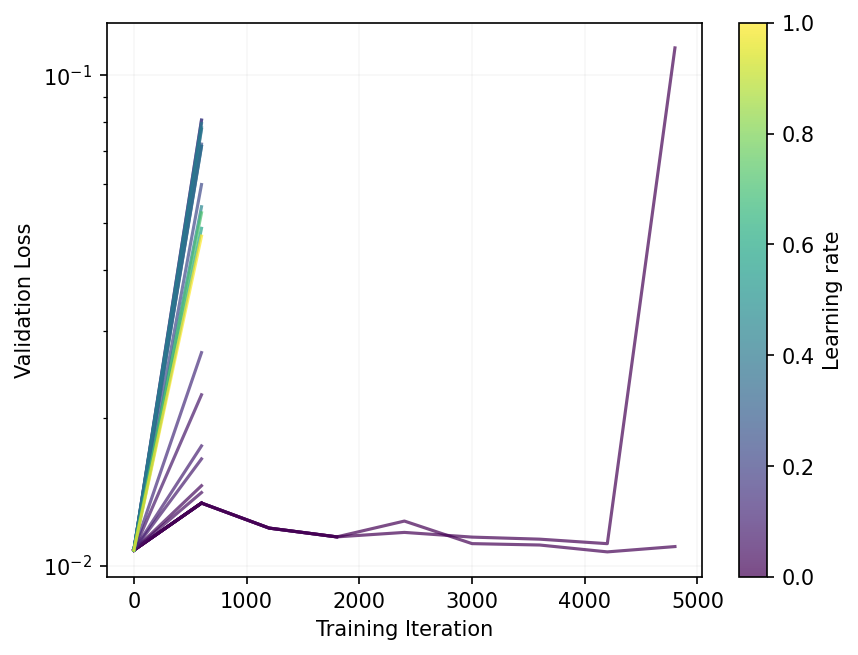

In [9]:
import matplotlib as mpl

# Sort results by learning rate
results = sorted(results, key=lambda x: x.config['learning_rate'])
lr = [r.config['learning_rate'] for r in results]


# Plot losses with color indicating lr value
cmap = mpl.colormaps['viridis']
fig, ax = plt.subplots(dpi=150)
for i, result in enumerate(results):
    # Get the data from the result grid.
    data = result.metrics_dataframe

    # Extract the hyperparameters and metric values.
    x_values = data["training_iteration"]
    y_values = data["val_loss"]

    # Create the plot.
    sc = ax.scatter(x_values, y_values, alpha=0.7,
            color=cmap((lr[i] - min(lr)) / (max(lr) - min(lr))))
    sc.remove()
    ax.plot(x_values, y_values, alpha=0.7,
            color=cmap((lr[i] - min(lr)) / (max(lr) - min(lr))))
    
ax.set_xlabel("Training Iteration")
ax.set_ylabel("Validation Loss")
ax.set_yscale("log")
ax.grid(alpha=0.1)
plt.colorbar(sc, label="Learning rate", ax=ax)
plt.show()

In [10]:
import numpy as np
import matplotlib as mpl

cmap = mpl.colormaps['viridis']

for it in np.arange(0, 1000, 100)+100:
    val_losses = [iter_loss(r.metrics_dataframe, it) for r in results]
    plt.scatter(lr, val_losses, color=cmap(it/1000), label=str(it))
plt.legend()
plt.yscale('log')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [13]:
results[0].metrics_dataframe

loss  val_loss  val_ema_loss  training_iteration    nan   timestamp  \
0  0.000000  2.062226      2.057610                   0  False  1699369515   
1  0.076331  0.074530      0.099655                 100  False  1699369651   
2  0.000000  2.062226      2.057610                   0  False  1699375306   
3  0.076331  0.074530      0.099655                 100  False  1699375464   
4  0.030144  0.026622      0.027914                 200  False  1699375624   
5  0.020296  0.019706      0.020020                 300  False  1699384901   

    done  trial_id                 date  time_this_iter_s  time_total_s  \
0  False  20d10498  2023-11-07_15-05-15         52.157464     52.157464   
1  False  20d10498  2023-11-07_15-07-31        136.322270    188.479734   
2  False  20d10498  2023-11-07_16-41-46         57.611580     57.611580   
3  False  20d10498  2023-11-07_16-44-24        158.385039    215.996619   
4  False  20d10498  2023-11-07_16-47-04        159.715859    375.712478   
5  False  20d10498  2023-11-07_19-21-41        147.204797    522.917275   

       pid hostname         node_ip  time_since_restore  \
0  2245793   hopper  134.100.120.74           52.157464   
1  2245793   hopper  134.100.120.74          188.479734   
2  2441650   hopper  134.100.120.74           57.611580   
3  2441650   hopper  134.100.120.74          215.996619   
4  2441650   hopper  134.100.120.74          375.712478   
5  2716283   hopper  134.100.120.74          147.204797   

   iterations_since_restore checkpoint_dir_name  config/learning_rate  \
0                         1                None               0.00014   
1                         2                None               0.00014   
2                         1                None               0.00014   
3                         2                None               0.00014   
4                         3   checkpoint_000000               0.00014   
5                         1                None               0.00014   

  should_checkpoint  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4              True  
5               NaN

# Sampling

In [2]:
from pathlib import Path
out_folder = Path("/home/bbd0953/diffusion/analysis_results/runtimes")

In [12]:
from pathlib import Path
from utils.sample_utils import sneak_peek, load_model_from_folder
import time
import torch
from torch.profiler import profile, record_function, ProfilerActivity
from tqdm import tqdm
from model.unet import Unet
from fvcore.nn import FlopCountAnalysis
from flops_profiler.profiler import get_model_profile


torch.backends.cudnn.benchmark = True

folder = Path("/home/bbd0953/diffusion/results/InitModel_EDM")
model = load_model_from_folder(folder)
device = torch.device("cuda:3")
model.to(device)
# model.eval()

# Test sampling speed for different batch sizes

batch_sizes = [16, 32, 64, 128, 256, 512]
times = []
stats = []
with torch.no_grad():
    for batch_size in batch_sizes:
        print(batch_size)
        # Imitate sampling call:
        latents = torch.randn([batch_size, 1, 80, 80], device=device)
        t_in = torch.full((batch_size,), 8., device=device)
        # Analyze execution time
        t0 = time.time()
        flops, macs, params = get_model_profile(model=model, # model
                                    input_shape=None,
                                    args=(latents, t_in), # list of positional arguments to the model.
                                    kwargs=None, # dictionary of keyword arguments to the model.
                                    print_profile=True, # prints the model graph with the measured profile attached to each module
                                    detailed=True, # print the detailed profile
                                    module_depth=-1, # depth into the nested modules, with -1 being the inner most modules
                                    top_modules=1, # the number of top modules to print aggregated profile
                                    warm_up=10, # the number of warm-ups before measuring the time of each module
                                    as_string=True, # print raw numbers (e.g. 1000) or as human-readable strings (e.g. 1k)
                                    output_file=None, # path to the output file. If None, the profiler prints to stdout.
                                    ignore_modules=None, # the list of modules to ignore in the profiling
                                    func_name='forward')
        flops.append([flops, macs, params])
        torch.cuda.synchronize()
        t1 = time.time()
        times.append(t1 - t0)
        del latents
        del t_in
        # del out
        torch.cuda.empty_cache()
del model
torch.cuda.empty_cache()

16


TypeError: _upsample_flops_compute() takes 1 positional argument but 5 were given

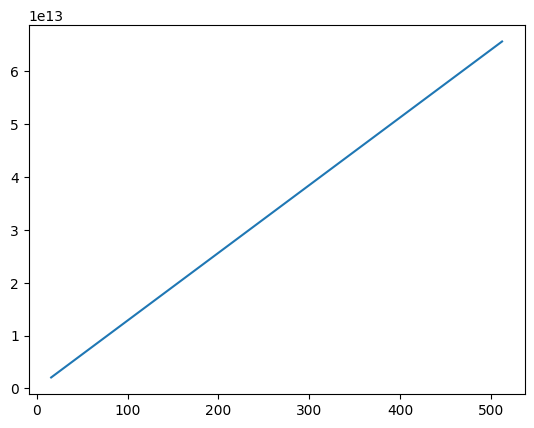

In [6]:
import matplotlib.pyplot as plt
plt.plot(batch_sizes, flops)

Text(0.5, 1.0, 'Test Inference Time with EDM Initial Model (mock sampling, 10 calls)')

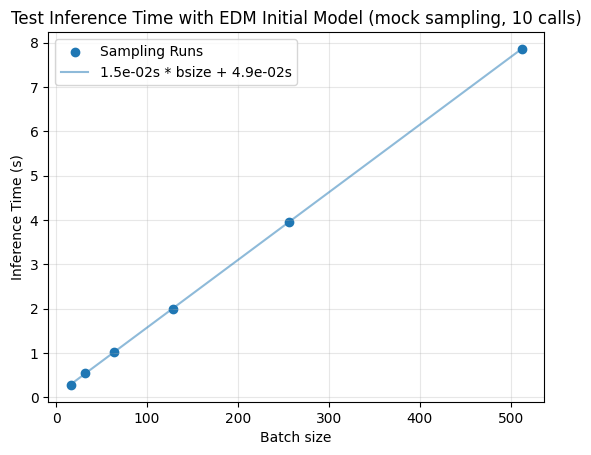

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# convert lists to np arrays
batch_sizes = np.array(batch_sizes)
times = np.array(times)
times_iter = times / 5
paces = times / batch_sizes

plt.figure()
plt.scatter(batch_sizes, times, label="Sampling Runs")
# Fit a linear function
p = np.polyfit(batch_sizes, times, 1)
fit_desc= f"{p[0]:.1e}s * bsize + {p[1]:.1e}s"
plt.plot(batch_sizes, np.polyval(p, batch_sizes), alpha=0.5, label=fit_desc)
plt.grid(alpha=0.3)
plt.xlabel("Batch size")
plt.ylabel("Inference Time (s)")
plt.legend()
plt.title("Test Inference Time with EDM Initial Model (mock sampling, 10 calls)")
# plt.savefig(out_folder / "inference_time.pdf", dpi=300)


In [16]:

model_file = "/home/bbd0953/diffusion/results/DDPM_23-09-01_08:03:11.pt"
ema_file = "/home/bbd0953/diffusion/results/DDPM_23-09-01_08:03:11_EMA.pt"

bsize = 36  # Should have integer square root

model = Unet(dim=160, image_channels=1, channel_mults=(1, 2, 3, 4)).to('cuda:1')
model.load_state_dict(torch.load(model_file))

diffusion = Diffusion(timesteps=1000)

imgs = diffusion.sample(model, 80, batch_size=bsize)[-1]  # Only last time step

model.load_state_dict(torch.load(ema_file))
imgs_ema = diffusion.sample(model, 80, batch_size=bsize)[-1]

model = model.to('cpu');

Sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

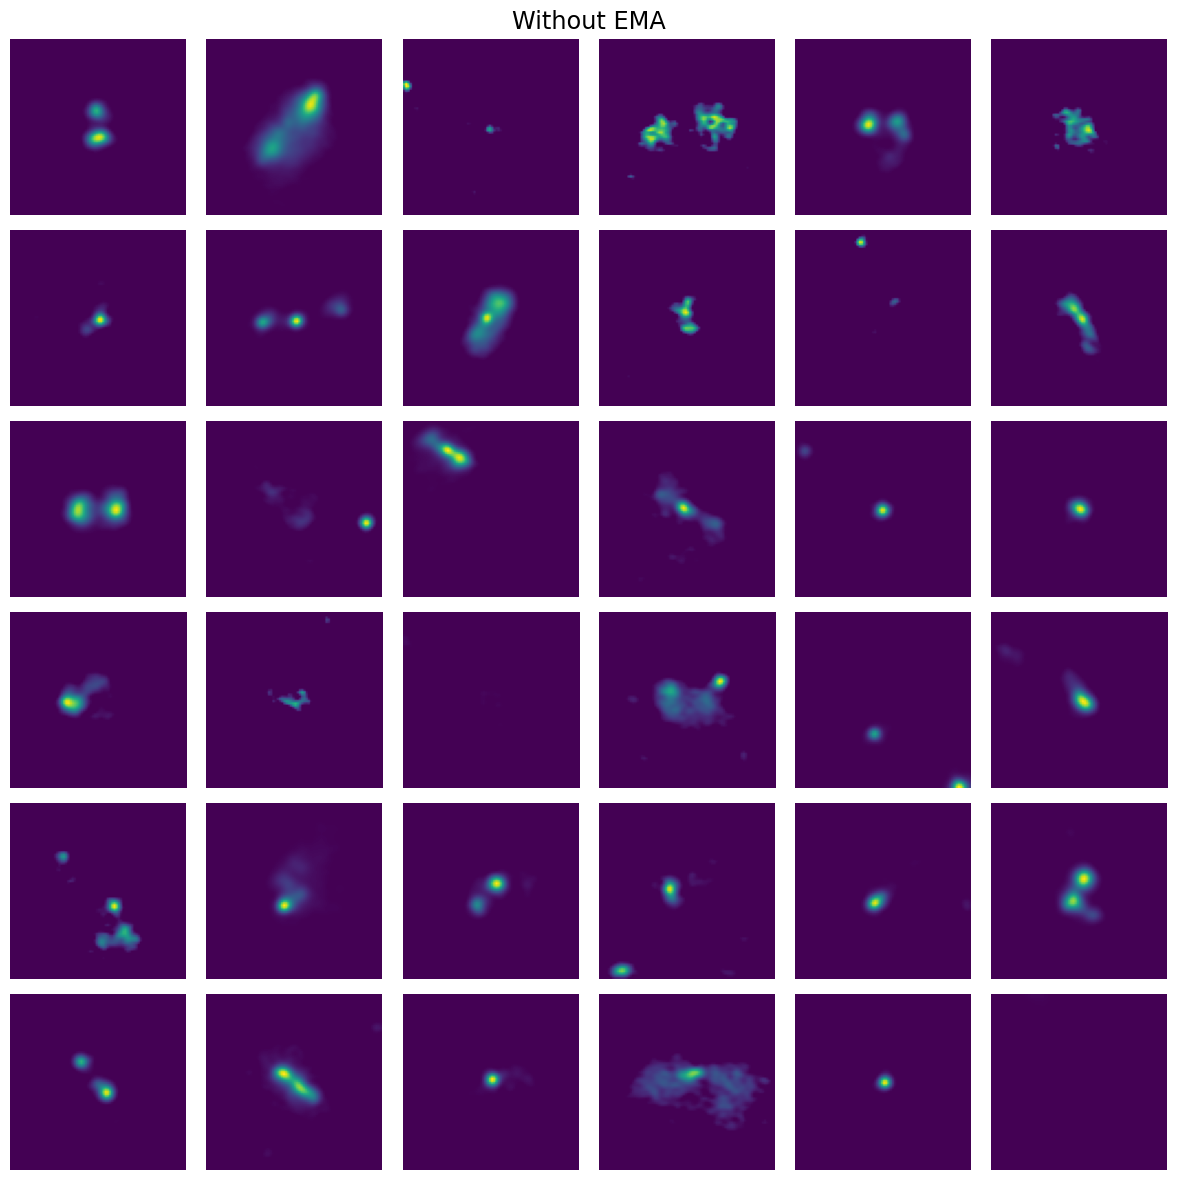

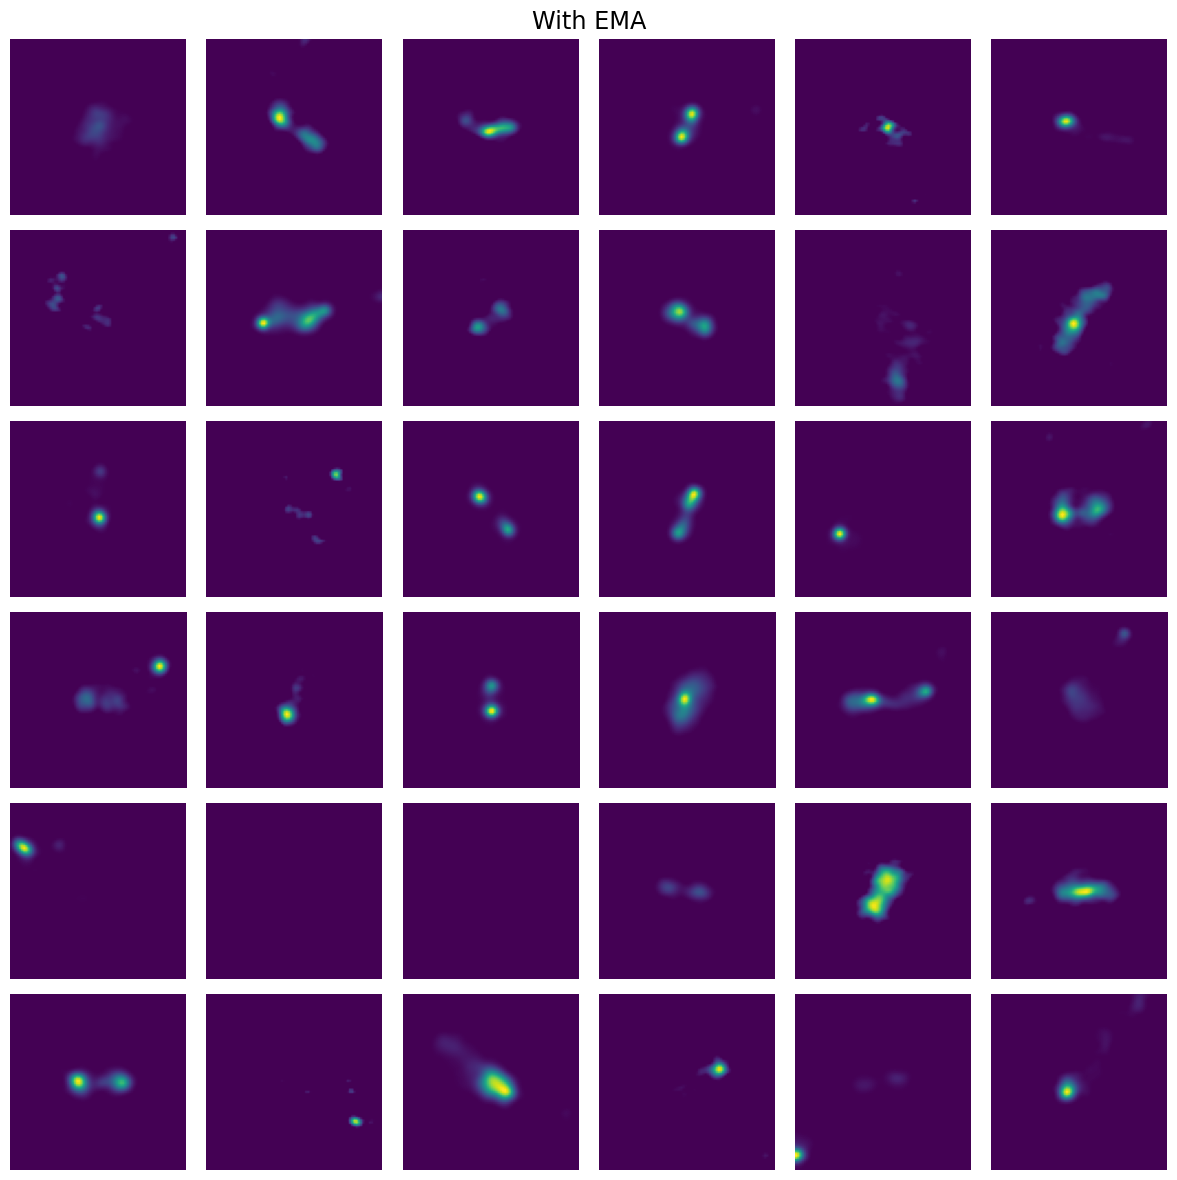

In [20]:
plot_samples(imgs, title="Without EMA")
plot_samples(imgs_ema, title="With EMA");

# Existing Data

## Real Data

Loading images...


100%|██████████| 84411/84411 [00:02<00:00, 35935.41it/s]


Data set initialized.


(<Figure size 1200x1200 with 25 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

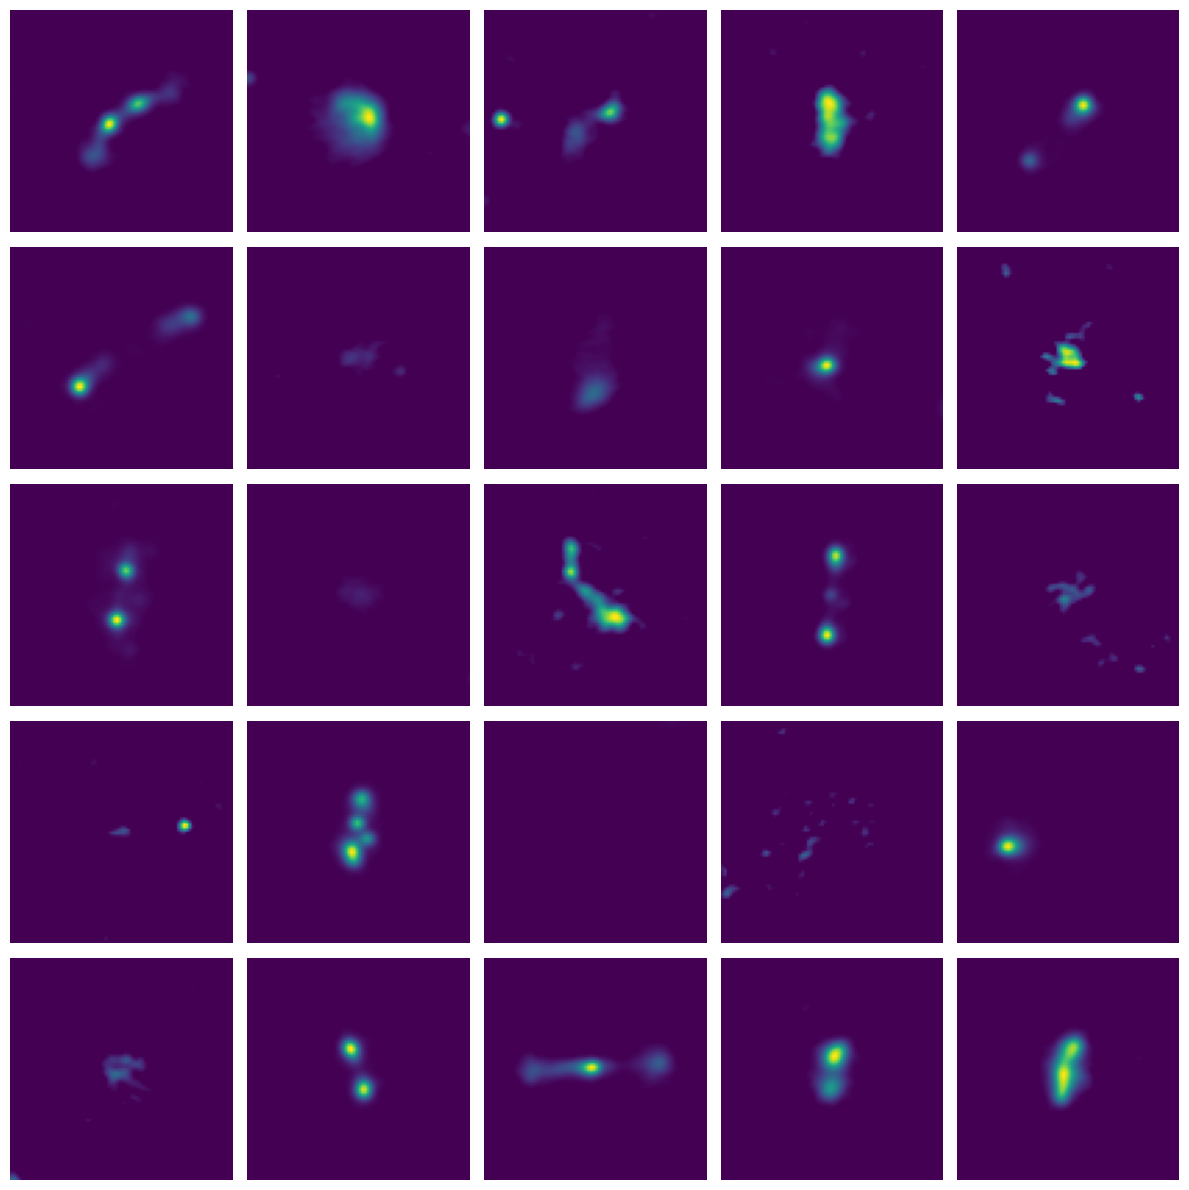

In [4]:
from lofar_data import LofarUnlabeled
from utils import plot_samples
from torchvision.transforms import ToTensor, Compose, CenterCrop
from torch.utils.data import DataLoader

transform = Compose([
        ToTensor(),
        CenterCrop(80),
        lambda x: x * 2 - 1,  # Scale to [-1, 1]
    ])

data = LofarUnlabeled(root="./data", transform=transform,
                        las_thr=[40, 120], flux_thr=5)
dataloader = DataLoader(data, shuffle=True, batch_size=25)

batch = next(iter(dataloader))
plot_samples(batch)

## Generated Data

In [3]:
import torch
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, CenterCrop
from model.utils import plot_samples
from model.utils import clip_and_rescale

class ImagePathDataset(torch.utils.data.Dataset):
    # From:
    #  https://github.com/mseitzer/pytorch-fid/blob/master/src/pytorch_fid/fid_score.py
    def __init__(self, path, transforms=None):
        self.path = path
        self.files = sorted(self.path.iterdir())
        self.transforms = transforms

        print("Loading images...")
        load = lambda f: Image.open(f)
        self.data = list(map(load, tqdm(self.files)))

        print("Data set initialized.")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        img = self.data[i]
        if self.transforms is not None:
            img = self.transforms(img)
        return img


In [63]:
lofar_img_path = Path("./data/images-lofar_unlabeled")

files = sorted([file for file in lofar_img_path.glob("*")])
f = files[0]
f

PosixPath('data/images-lofar_unlabeled/annotation-lofar_unlabeled.csv')

In [15]:
gen_path = Path("./data/generated/diffusion_v1.0_DDIM")

transform = Compose([
        ToTensor(),
        CenterCrop(80),
        lambda img: img[:1,:,:],  # First channel only
        # lambda img: clip_and_rescale(img)
    ])
gen_data = ImagePathDataset(gen_path, transforms=transform)

Loading images...


100%|██████████| 13500/13500 [00:01<00:00, 13002.36it/s]

Data set initialized.


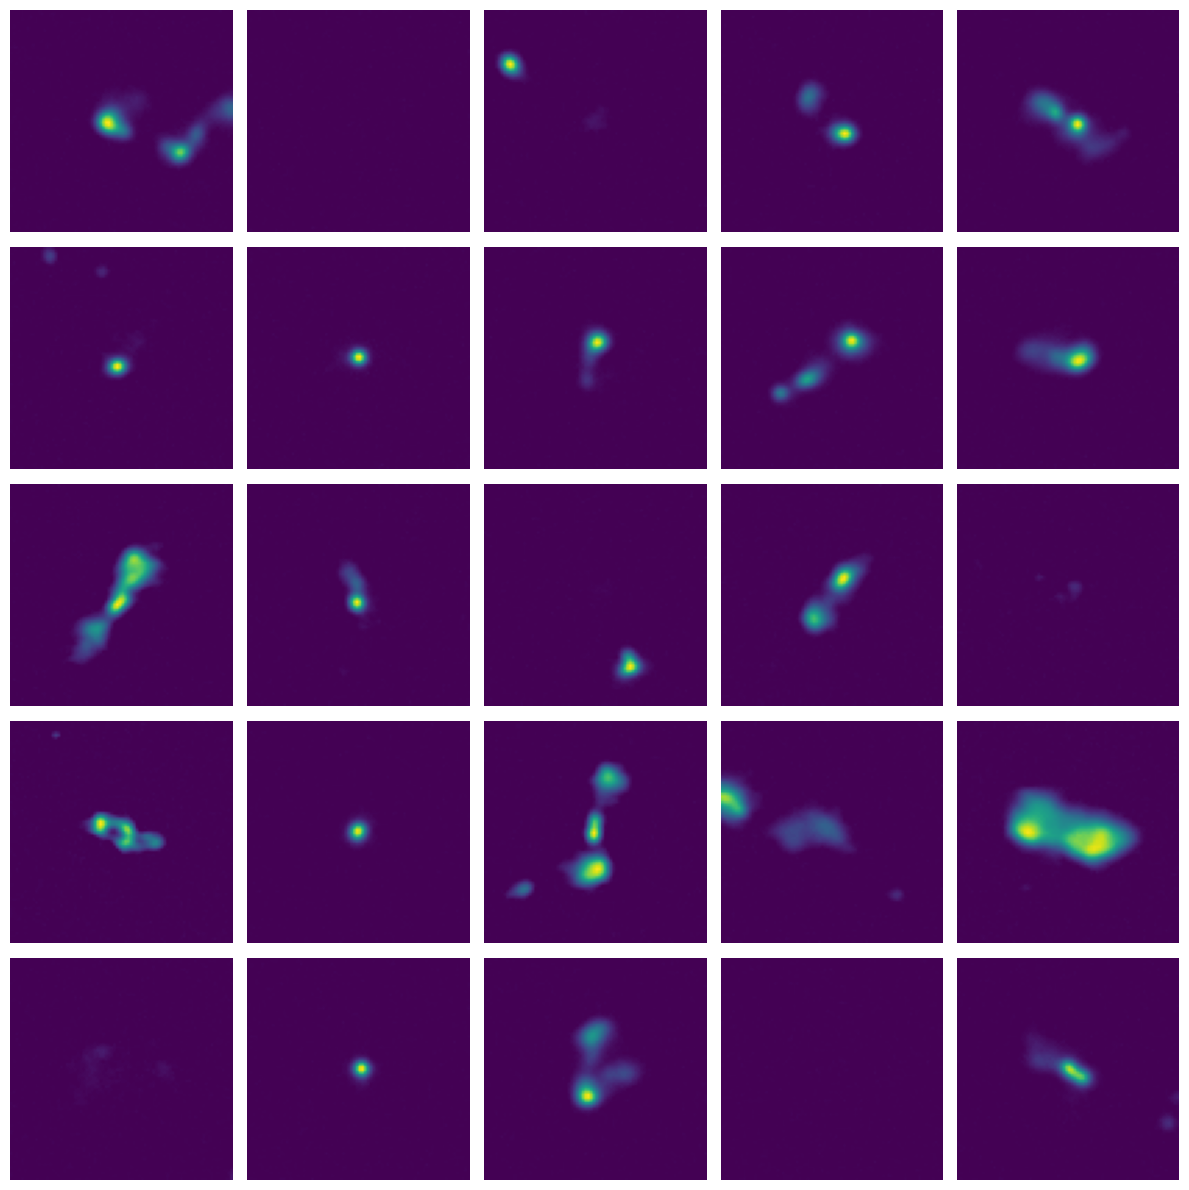

In [16]:
gen_dl = DataLoader(gen_data, batch_size=25, shuffle=True)

batch = next(iter(gen_dl))
plot_samples(batch, vmin=0);